# MAT5014 - Economic research - Suicide rates
*Authors: BRAYE Valérien, CHHAY Ly An, ROLLAND Georges* <br>
*Language: Python 3* <br>
*Last modified: 01/15/2024* <br>
*Institution: Télécom SudParis* <br>
*Datasets: [Suicide Rates Overview 1985 to 2016](https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016), [Gender wage gap](https://data.oecd.org/earnwage/gender-wage-gap.htm)* <br>
*Code: [https://github.com/brayevalerien/Suicide-rates](https://github.com/brayevalerien/Suicide-rates)* <br>

## I. Introduction

### Motivation

> Suicide is a complex phenomenon that finds its root in multiple economical, social and individual causes. This scourge impacts very few people but every society experiences it, at different levels. <br>
> Gaining a better understanding of the causes of suicides could make it easier for authorities to provide help for those who seek it, estimate the risk of suicide in an area but also help future work on this topic.

### Problem

>In this study, we use real world data gathered since the 70s all around the globe to propose a model describing the suicide rate in a population depending on some economical parameters, such as the [Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index), the [Gross Domestic Product](https://en.wikipedia.org/wiki/Gross_domestic_product) but also the gender wage gap. <br> 

>Furthurmore we also want to study the impact of inequality parameters, such as the Gender Inequality Index, and the Sex-ratio at birth on suicide rate between men-women. We want to know whether inequality might contribute to more female committing suicide in comparison to men do in a population or not. 

### General plan

> Firstly, we will have to define some setup variables and code. <br>
> Then, we perform a full Exploratory Data Analysis (EDA) on both datasets. <br>
> The next section is dedicated to testing five models in order to find out which one works the best for our problem. We try using univariate and multivariate linear regressions, decision trees and random forests, as well as applying a PCA before performing a linear regression in the resulting space. <br>
> As an additionnal analysis, we also study the relationship between the [Gender Inequality Index](https://en.wikipedia.org/wiki/Gender_Inequality_Index) and the male/female suicides ratio. Alth>ough this analysis does not help improving our model, the results it yield are worth taking a look at.

## Imports and preliminary code
> The following cell defines usefull global variables to configure this notebook.
>- `DATAPATH`: change this to the path to the directory where the datasets are stored.
>- `SAVEFIGS`: weither to save the figures to disk or not. Saved figures will not have titles in order to make them easier to use outside of this notebook.
>- `FIGPATH`: path where the figures will be saved if `SAVEFIGS` is set to `True`.
>- `SEED`: a seed used for all random procedures to make the results reproducible. Use system time if you want fully randomized results.
>- `USEPX`: due to their dynamic nature, plotly express plots can make a notebook laggy and yield inconsistent results when exporting the notebook to HTML or PDF. Switch this variable to `False` to ignore plotly plots.

In [1]:
DATAPATH = "./data/"
SAVEFIGS = False
FIGPATH = "./figures/"
SEED = 42
USEPX = True

> The following cell imports all necessary libraries and might take a bit to run. We only use libraries that should already be installed with your Python installation, but if you get an error, install or update the required libraries yourself.

In [2]:
import itertools
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

# Joining tables and predicting using rf-reg tend to produce useless warning.
# We disable them to produce cleaner output. 
warnings.filterwarnings("ignore")

> Now, we define a publication-ready `pyplot` theme, taken from [github](https://github.com/matplotlib/matplotlib/issues/19028).

In [3]:
plot_settings = {'ytick.labelsize': 16,
                 'xtick.labelsize': 16,
                 'font.size': 22,
                 'figure.figsize': (10, 5),
                 'axes.titlesize': 22,
                 'axes.labelsize': 18,
                 'lines.linewidth': 2,
                 'lines.markersize': 3,
                 'legend.fontsize': 11,
                 'mathtext.fontset': 'stix',
                 'font.family': 'STIXGeneral'}
plt.style.use(plot_settings) # apply defined settings to current pyplot style

> The cell below defines some useful functions for our models exploration.

In [4]:
def sort_by_value(d: dict) -> dict:
    """
    Sorts a dict by its values (that must be "sortable" with the base sorted function)

    Args:
        d (dict)

    Returns:
        dict: d, sorted by value
    """
    return {k: v for k, v in sorted(d.items(), key=lambda x: x[1])}
        
def powerset(features: list[str]):
    """
    Args:
        features (list[str])

    Returns:
        a generator of the powerset of the list of features (e.g. ["a", "b"] -> ((), (a), (b), (a, b)))
    """
    return (list(comb)
            for k in range(len(features)+1)
            for comb in itertools.combinations(features, k))
    
def print_list(l: list, title: str = None, bullet: str = "•", max_items: int = None, randomize: bool = False, indent_level: int = 0) -> None:
    """
    Prints a list nicely. Handles sublists. Tupples will be displayed as items: ('e1', 'e2', ...).
    Parameters:
        • l: list to print
        • title: title of the list
        • bullet: bullet point to use
        • max_items: maximum number of items to print
        • randomize: pick random elements or not
        • indent_level: indentation level for sub-lists
    """
    if title:
        print(f"{indent_level * '  '}{title}:")
        indent_level += 1
    final_list_to_print = l.copy()
    if randomize:
        random.shuffle(final_list_to_print)
    if max_items:
        final_list_to_print = l[:max_items]
    for item in final_list_to_print:
        if isinstance(item, list):
            print_list(item, bullet=bullet, indent_level=indent_level+1)
        elif isinstance(item, tuple):
            print(f"{indent_level * '  '}{bullet} {str(item)}")
        else:
            print(f"{indent_level * '  '}{bullet} {item}")
    if len(final_list_to_print) != len(l):
        print(f"{indent_level * '  '}...")

> Now that our environment is all set up, we can start our Exploratory Data Analysis.

## II. Exploratory Data Analysis
> In a world where the silent epidemic of suicide claims approximately [700,000](https://news.un.org/fr/story/2023/09/1138447) lives each year, we embark on a data-driven exploration. This study intertwines global suicide rates with the pervasive issue of gender wage gaps as we previously highlight. Through meticulous exploratory analysis, we aim to unveil patterns within datasets, shedding light on the intricate connections between these critical societal markers. Join us on this investigative journey as we attempt to get to the bottom of the economic impact of suicides.
>
> In this work, we will use two datasets:
>- [Suicide Rates Overview 1985 to 2016](https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016)
>- [Gender wage gap](https://data.oecd.org/earnwage/gender-wage-gap.htm)
>
> The first database studied here concerns data used to describe and study the suicide rates for different countries from 1985 to 2016. It was obtained from Kaggle and can be accessed at the previous link. Meanwhile, the second dataset gives, for different countries, the wage gap that exists between male and female people over a period from 1970 to 2022. It was retrieved from the OECD (Organisation for Economic Co-operation and Development).<br>
> First, we will explore the suicides dataset, then the gender wage gap one, to finally try to link both dataset and improve our understanding of the subject.

### 1. Suicides dataset

> Let us begin by loading our dataset and try to visualize the dataframe.

In [5]:
# Load dataset
suicides = pd.read_csv(DATAPATH + "suicides.csv")

In [6]:
# Dimension of our dataset
print(f"Dataset dimensions: {suicides.shape[0]} × {suicides.shape[1]}")

Dataset dimensions: 27820 × 12


In [7]:
# First instances of our dataset
suicides.head()

country  year     sex          age  suicides_no  population  \
0  Albania  1987    male  15-24 years           21      312900   
1  Albania  1987    male  35-54 years           16      308000   
2  Albania  1987  female  15-24 years           14      289700   
3  Albania  1987    male    75+ years            1       21800   
4  Albania  1987    male  25-34 years            9      274300   

   suicides/100k pop country-year  HDI for year  gdp_for_year ($)   \
0               6.71  Albania1987           NaN      2,156,624,900   
1               5.19  Albania1987           NaN      2,156,624,900   
2               4.83  Albania1987           NaN      2,156,624,900   
3               4.59  Albania1987           NaN      2,156,624,900   
4               3.28  Albania1987           NaN      2,156,624,900   

   gdp_per_capita ($)       generation  
0                 796     Generation X  
1                 796           Silent  
2                 796     Generation X  
3                 796  G.I. Generation  
4                 796          Boomers

> One of the easiest way to understand a dataset is to take a quick look at some random samples to examine their structure.

In [8]:
# Random lines in our dataframe
suicides.sample(5, random_state=SEED)

country  year     sex          age  suicides_no  \
17437                   Netherlands  2015    male   5-14 years            1   
23991                     Sri Lanka  2001  female    75+ years           31   
8337                    El Salvador  2013  female  35-54 years           19   
21661  Saint Vincent and Grenadines  1987  female    75+ years            0   
6235                     Costa Rica  2003  female    75+ years            0   

       population  suicides/100k pop                      country-year  \
17437      987750               0.10                   Netherlands2015   
23991      222745              13.92                     Sri Lanka2001   
8337       748153               2.54                   El Salvador2013   
21661        1500               0.00  Saint Vincent and Grenadines1987   
6235        54020               0.00                    Costa Rica2003   

       HDI for year  gdp_for_year ($)   gdp_per_capita ($)       generation  
17437           NaN    757,999,453,314               47206     Generation Z  
23991           NaN     15,749,753,805                 912           Silent  
8337          0.664     21,977,401,900                3885     Generation X  
21661           NaN        175,580,630                1908  G.I. Generation  
6235            NaN     17,195,867,540                4583           Silent

In [9]:
# The different variables of our dataframe
print_list(suicides.columns, "Variables in dataset")

Variables in dataset:
  • country
  • year
  • sex
  • age
  • suicides_no
  • population
  • suicides/100k pop
  • country-year
  • HDI for year
  •  gdp_for_year ($) 
  • gdp_per_capita ($)
  • generation


In [10]:
# Number of countries
print(f"Number of countries present in the dataset: {suicides['country'].nunique()}")

Number of countries present in the dataset: 101


> From the results above, we can notice that our dataset encompasses 27,820 instances, each described according to 12 explanatory variables. We have almost 30000 records from 1985 to 2016, related to 101 countries  from all around the world. For each record or instance, the 12 features are :
>- `country`: The associated country to a given instance,
>- `year`: The associated year to a specific record,
>- `sex`: The gender of the person for a record (`"male"` or `"female"`)
>- `age`: The age category,
>- `suicide_no`: The number of suicides for the same country, sex, year and age category, 
>- `population`: The population size of the country, sex and age category,
>- `suicides/100k pop`: The suicide rate per 100,000 inhabitants in the country,
>- `country-year`: The concatenation of the country and year variables in a single one,
>- `HDI for year`: The Human Development Index (HDI) of the year,
>- ` gdp_for_year ($)`: The Gross Domestic Product (GDP) for the year in dollars,
>- `gdp_per_capita ($)`: The GDP per inhabithant in a given year, estimated in dollars,
>- `generation`: generation of the person.
>
> Each of these variables serves in one way or another to describe the data in our dataframe. However, some of them may be redundant or simply not very relevant to our study. That's what we're going to look at now.

#### 1.1. Data preparation for suicides dataset
> In this section, we try to exclude outliers, remove `NaN`s and more generally make the data easier to work with. <br>
First of all, some of the variable names used in the original dataset do not respect snake case, so we will rename them for ease of use.

In [11]:
# Mapping for renaming the columns of the dataframe
columns_rename_map = {
    "suicides/100k pop": "suicides_rate",
    "country-year": "country_year",
    "HDI for year": "hdi",
    " gdp_for_year ($) ": "gdp",
    "gdp_per_capita ($)": "gdp_per_capita",
} 

# Renaming of the columns
suicides.rename(columns_rename_map, axis=1, inplace=True);

> We can also remove useless columns by the way. Since they are redundant with the rest of the data, we will remove variables `country_year` and `generation`. Indeed, these variables are already available in the dataset, in particular with the `country`, `year` and `age` variables. 

In [12]:
# Drop of 'country_year' and 'generalion' columns
suicides.drop(["country_year", "generation"], axis=1, inplace=True)

>To make it easier to manipulate the `age` variable, we will transform it according to the table below:

| Original age value | New age value |
| -------------------- | --------------- |
| `"5-14 years"`       | `0`             |
| `"15-24 years"`      | `1`             |
| `"25-34 years"`      | `2`             |
| `"35-54 years"`      | `3`             |
| `"55-74 years"`      | `4`             |
| `"75+ years"`        | `5`             |

> Unfortunatly, not all age categories are of the same size: the two last ones are 20 years long while the first ones are 10 years long. It is necessary to keep this information in mind later in the study. <br>
To compensate this issue, we will add two variables `age_min` and `age_max`, respectively the minimum and maximum possible for the considered person in new columns. <br>
We will still keep the old `age` variable but rename it to `age_category`.

In [13]:
# New column 'age_category'
suicides["age_category"] = suicides.age

# Map used for replacing the age by different classes
age_map = {
    "5-14 years": 0,
    "15-24 years": 1,
    "25-34 years": 2,
    "35-54 years": 3,
    "55-74 years": 4,
    "75+ years": 5
}

# Convert the age values using the create map
suicides.age = suicides.age.map(age_map)

# New columns for the minimum age of a category
suicides["age_min"] = suicides.age.map({
    0: 5,
    1: 15,
    2: 25,
    3: 35,
    4: 55,
    5: 75
})

# New columns for the maximum age of a category
suicides["age_max"] = suicides.age.map({
    0: 14,
    1: 24,
    2: 34,
    3: 54,
    4: 74,
    5: 94 # chosen to make the category 20 years long
})

> Now that it is done, we can notice that the `gdp` variable is an object and not a float64 or an int. This is because it uses the american notation, separating 3 digit groups by commas. For instance, `2156624900` is represented by `2,156,624,900`. We will convert it to int in order to be able to manipulate them. 

In [14]:
# Casting gdp values to integers
suicides.gdp = suicides.gdp.apply(lambda x: int(x.replace(",", "")))

> Next, we need to check for missing data.

In [15]:
# Checking of the percentage of missing values for each column
for variable in suicides.columns:
    try:
        print(f"{suicides[variable].value_counts(normalize=True, dropna=False)[np.nan]*100:.1f}% of values are missing for variable {variable}.")
    except KeyError:
        print(f"No nan value for variable {variable}.")

No nan value for variable country.
No nan value for variable year.
No nan value for variable sex.
No nan value for variable age.
No nan value for variable suicides_no.
No nan value for variable population.
No nan value for variable suicides_rate.
69.9% of values are missing for variable hdi.
No nan value for variable gdp.
No nan value for variable gdp_per_capita.
No nan value for variable age_category.
No nan value for variable age_min.
No nan value for variable age_max.


> There is no missing data except for the `hdi` variable, where more than two thirds of the values are missing. We could either:
>- drop the observations with a missing value, which is not acceptable given the proportion of missing values.
>- drop the `hdi` variable, but we suspect that it might be highly correlated to the number of suicides so it would be beneficial to keep it.
>- fill as much as possible the missing values. This is the option we will take.
>
> For each missing value, we will use the average `hdi` corresponding to the country. If there is not such record, we simply drop the observation.

In [16]:
def find_hdi(df: pd.DataFrame, country: str) -> int:
    """
    Return the average HDI of the country.
    If no record is found, returns -1.

    Args:
        df (pd.DataFrame): data
        country (str)
        year (int)

    Returns:
        int: HDI of country for year
    """
    records = df[df.country == country].dropna()
    if not records.empty:
        return records.hdi.mean()
    return -1

def fill_hdi_values(df: pd.DataFrame) -> int:
    """
    Fills missing values of the "hdi" variable of the provided dataframe.
    Missing values are filled using the average of existing values from the same country.

    Args:
        df (pd.DataFrame): data.

    Returns:
        int: number of missing values that were replaced.
    """
    memo = {} # stores, for each encountered country pair, the associated HDI
    replaced = 0
    for i, row in df.iterrows():
        if np.isnan(row["hdi"]):
            approx_hdi = -1
            if row["country"] in memo:
                approx_hdi = memo[row["country"]]
            else:
                approx_hdi = find_hdi(df, row["country"])
                memo[row["country"]] = approx_hdi
            if approx_hdi != -1:
                df.hdi[i] = approx_hdi
                replaced += 1
    return replaced

# Fill in missing values
missing_hdi = suicides.hdi.value_counts(dropna=False)[np.nan]
filled_hdi = fill_hdi_values(suicides)
print(f"Filled {filled_hdi} ({filled_hdi/missing_hdi*100:.1f}%) of missing HDI values. About {suicides.hdi.value_counts(normalize=True, dropna=False)[np.nan]*100:.1f}% values are still missing.")
suicides.dropna(inplace=True)
print("All missing values have been droped.")

Filled 17970 (92.4%) of missing HDI values. About 5.3% values are still missing.
All missing values have been droped.


> With this technique, we were able to go from 69% of missing values to about only 5%, that we droped.

#### 1.2. Data visualization of suicides dataset
> Now that the data preparation is done, we can explore it.
First of all, it would be great to know the different countries and how many years of records are provided for each of them. Let's visualize it.

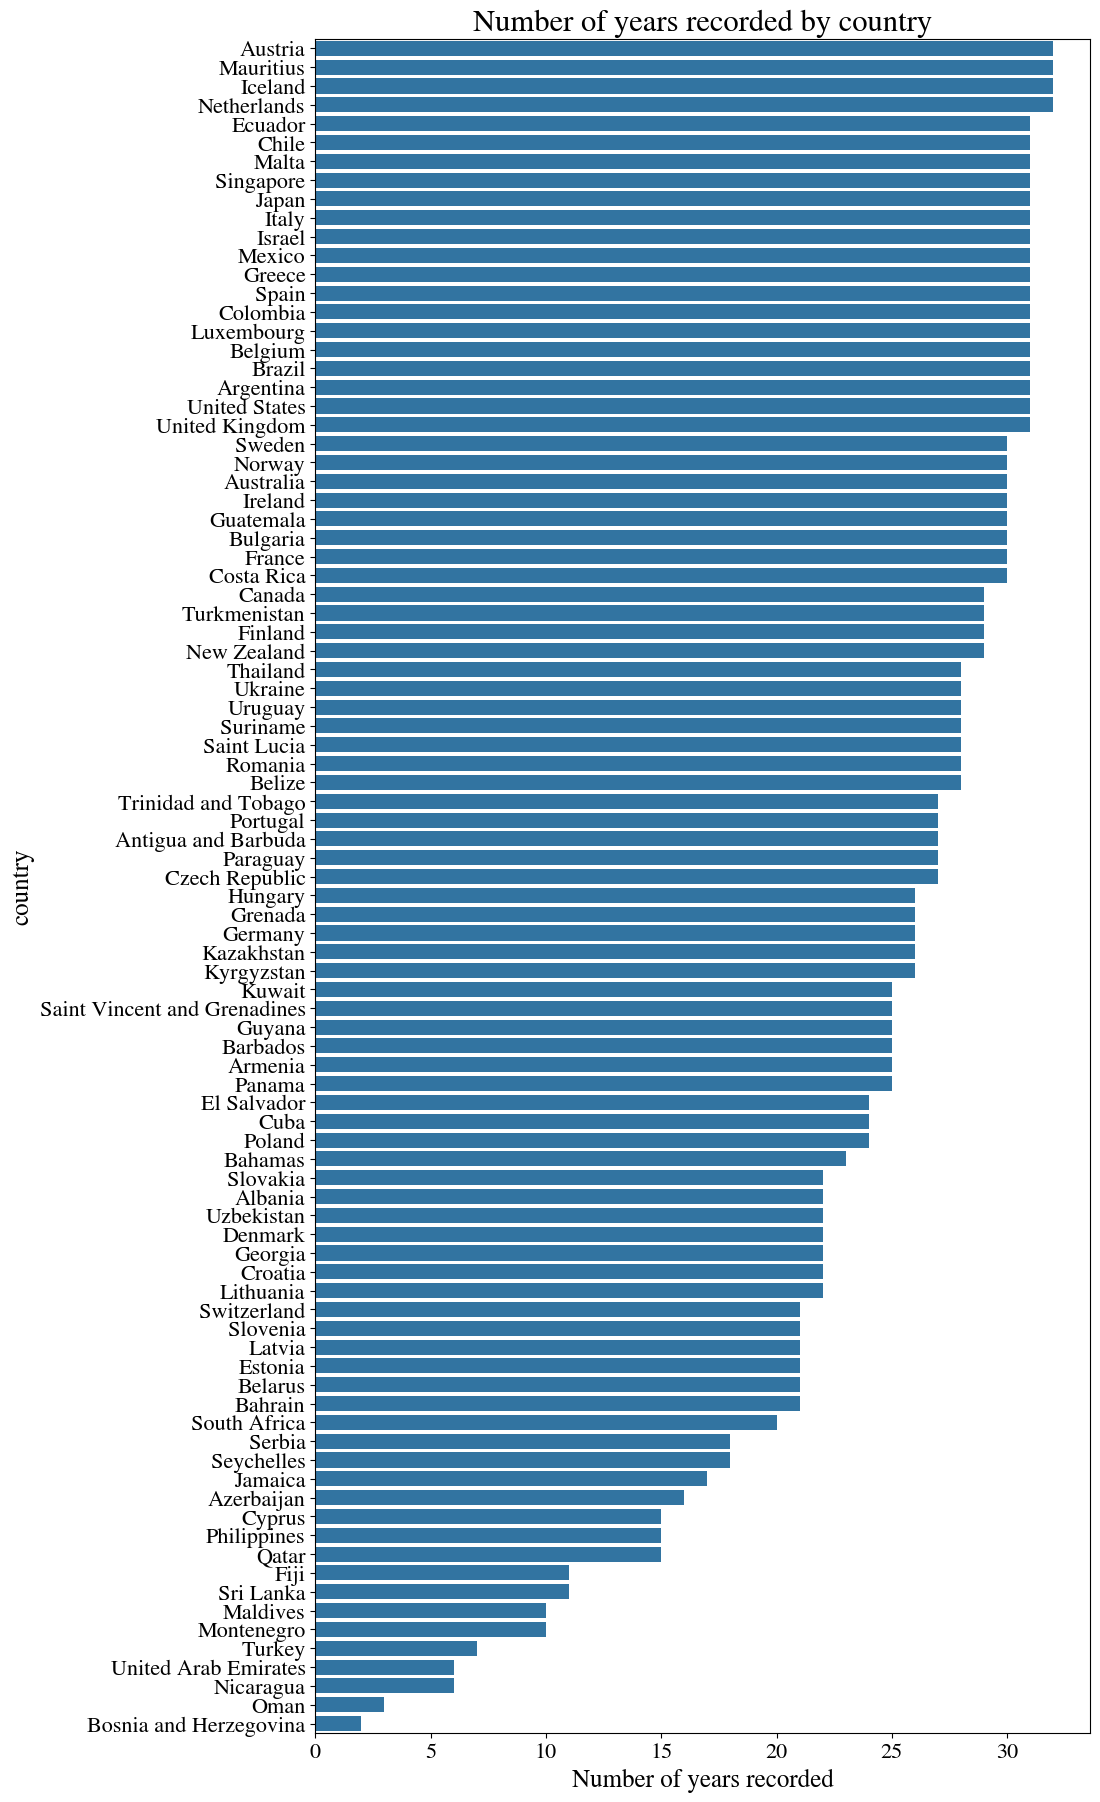

In [17]:
# Plot of the number of years of data for each country
years_count = suicides.groupby("country").year.nunique().sort_values(ascending=False)
plt.figure(figsize=(10, 22))
sns.barplot(years_count, orient="h")
plt.xlabel("Number of years recorded")
plt.title("Number of years recorded by country")
plt.show()

> We can notice that countries with the most records have about 30 years of data in the dataframe (so the whole time span of the study), but some other countries have only a few years recorded. This is an important observation because it will affect the further work. For instance, the use of the mean on suicide rate will not be really representative for countries with less records. However, most countries have at least 20 years recorded. So, it remains interesting to dive into deep analysis of our dataset. We will keep every countries for a first approach.

> Let us visualize now the average suicide rate for each country.

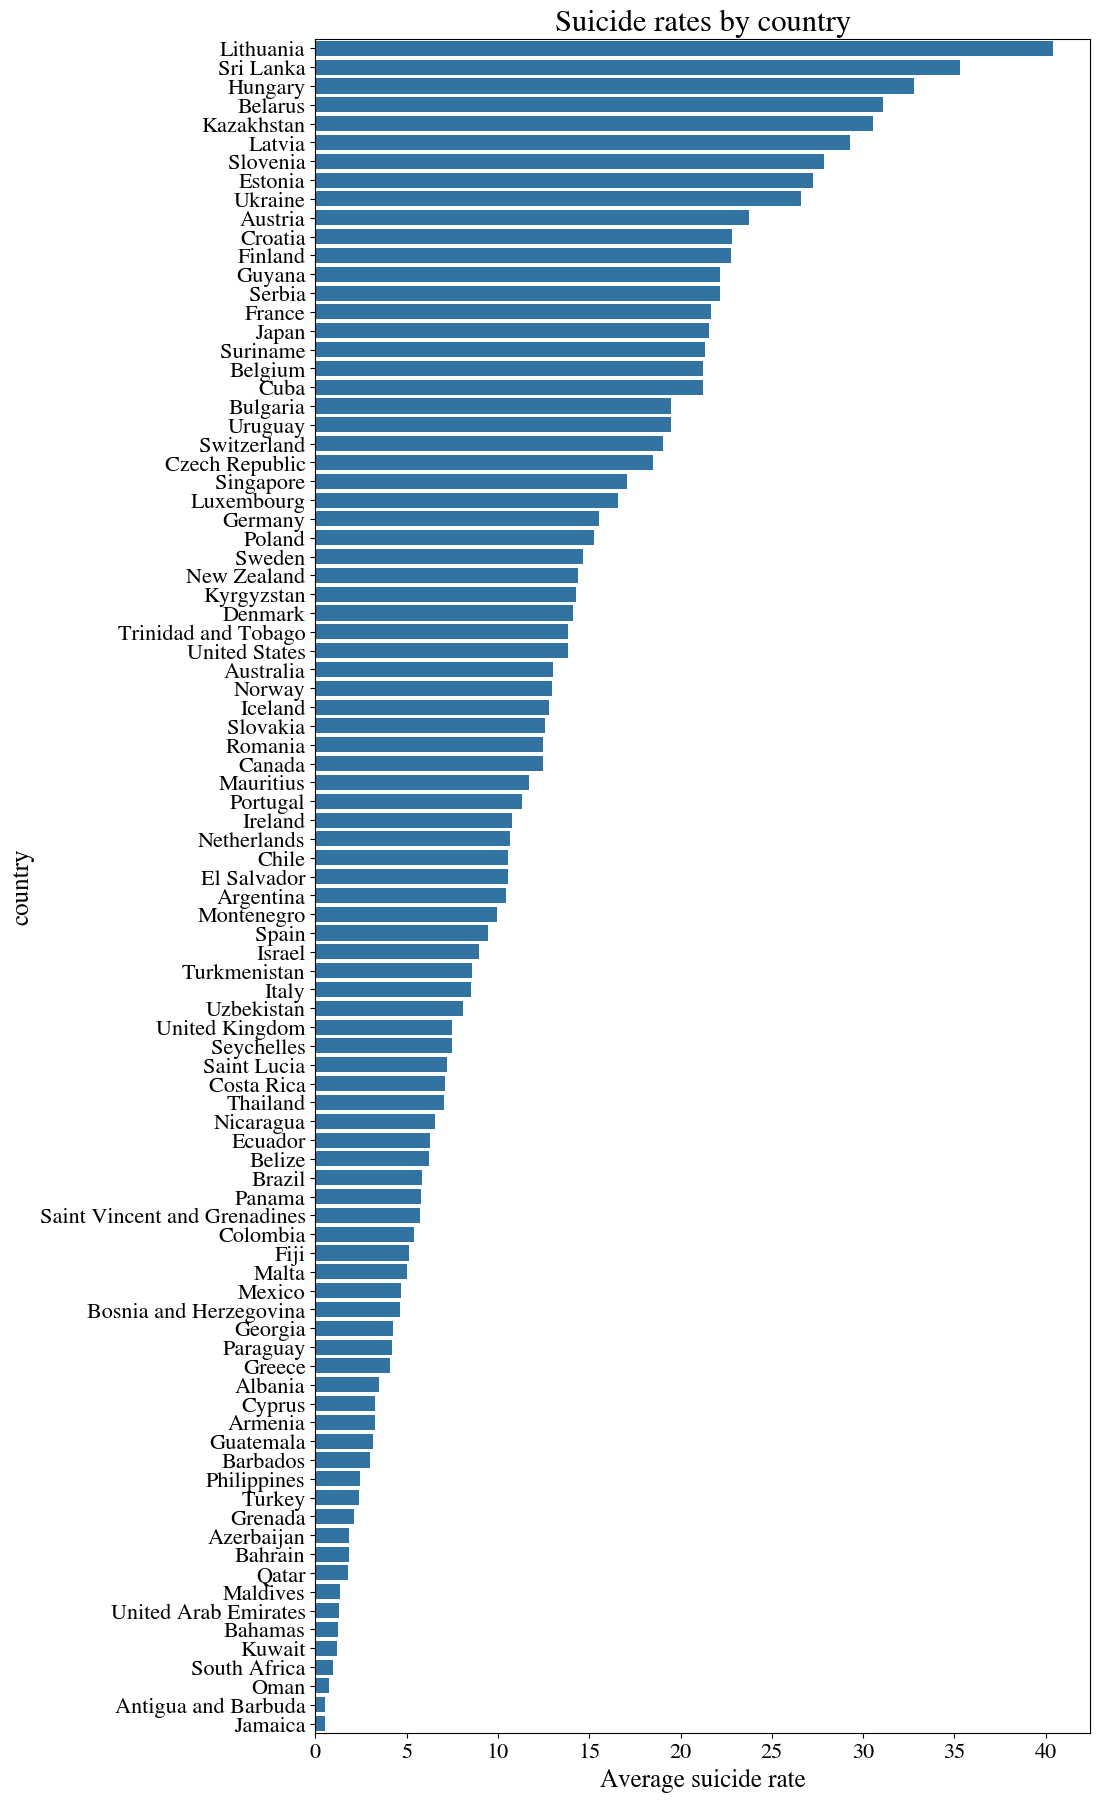

In [18]:
# Plot of the suicide rates average for each country
average_country_rates = suicides.groupby("country").suicides_rate.mean().sort_values(ascending=False)
plt.figure(figsize=(10, 22))
sns.barplot(average_country_rates, orient="h")
plt.xlabel("Average suicide rate")
plt.title("Suicide rates by country")
plt.show()

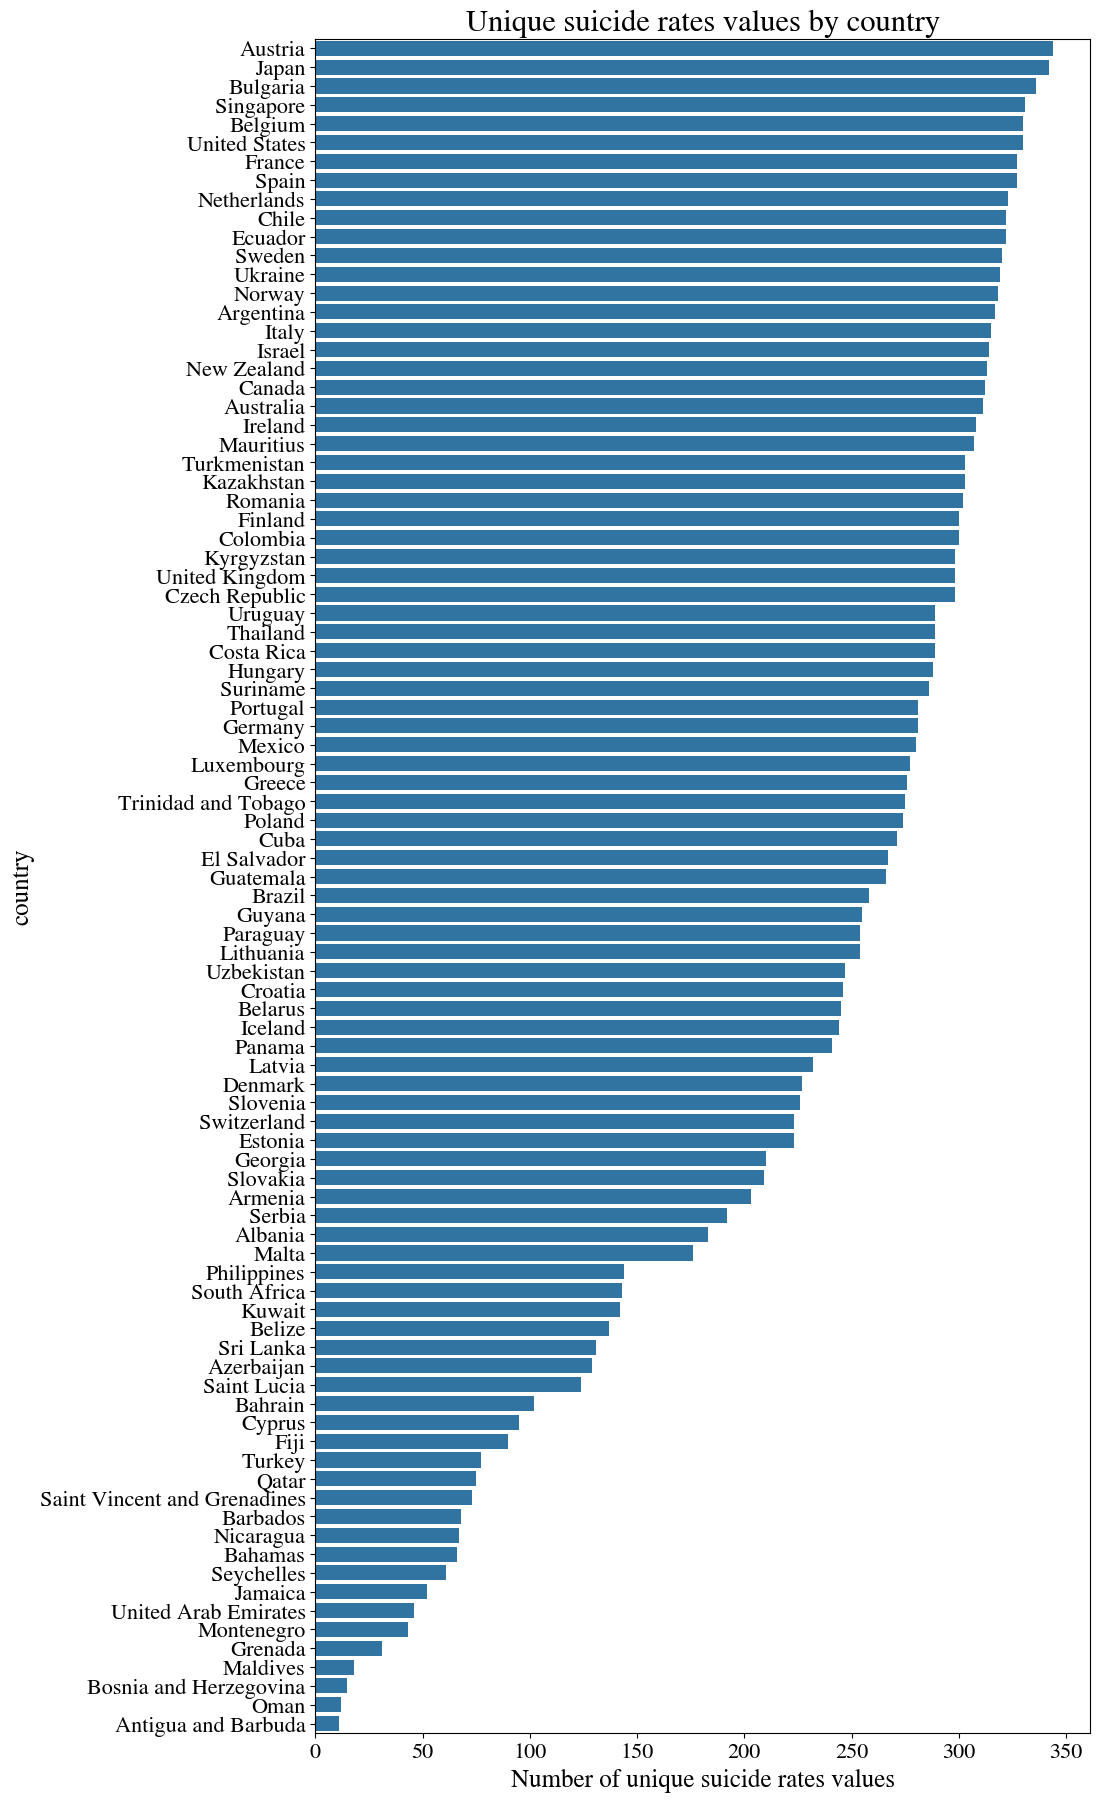

In [19]:
# Plot of the number of unique suicide rates values for each country
average_country_rates = suicides.groupby("country").suicides_rate.nunique().sort_values(ascending=False)
plt.figure(figsize=(6, 6))
sns.barplot(average_country_rates[:10], orient="h")
plt.xlabel("Number of unique suicide rates values")
plt.title("Unique suicide rates values by country")
plt.show()

In [ ]:
# Plot of the number of unique suicide rates values for each country
average_country_rates = suicides.groupby("country").suicides_rate.nunique().sort_values(ascending=False)
plt.figure(figsize=(6, 6))
sns.barplot(average_country_rates[10:], orient="h")
plt.xlabel("Number of unique suicide rates values")
plt.title("Unique suicide rates values by country")
plt.show()

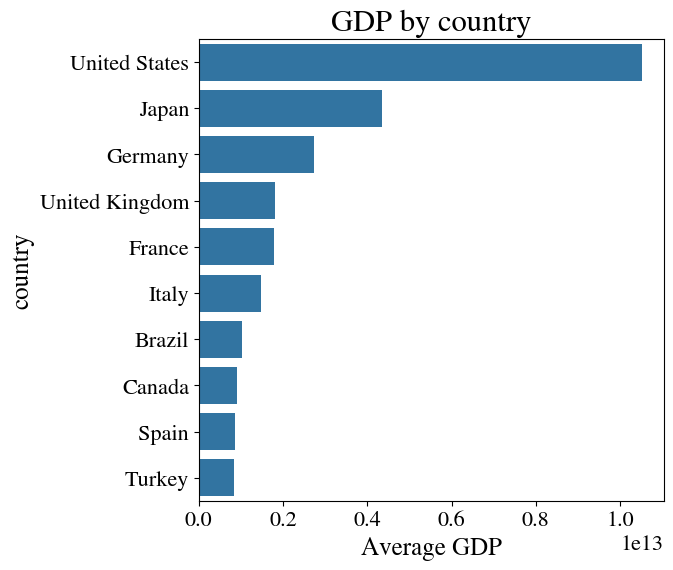

In [20]:
# Plot of the GDP average for each country
average_country_gdp = suicides.groupby("country").gdp.mean().sort_values(ascending=False)
plt.figure(figsize=(6, 6))
sns.barplot(average_country_gdp[:10], orient="h")
plt.xlabel("Average GDP")
plt.title("GDP by country")
plt.show()

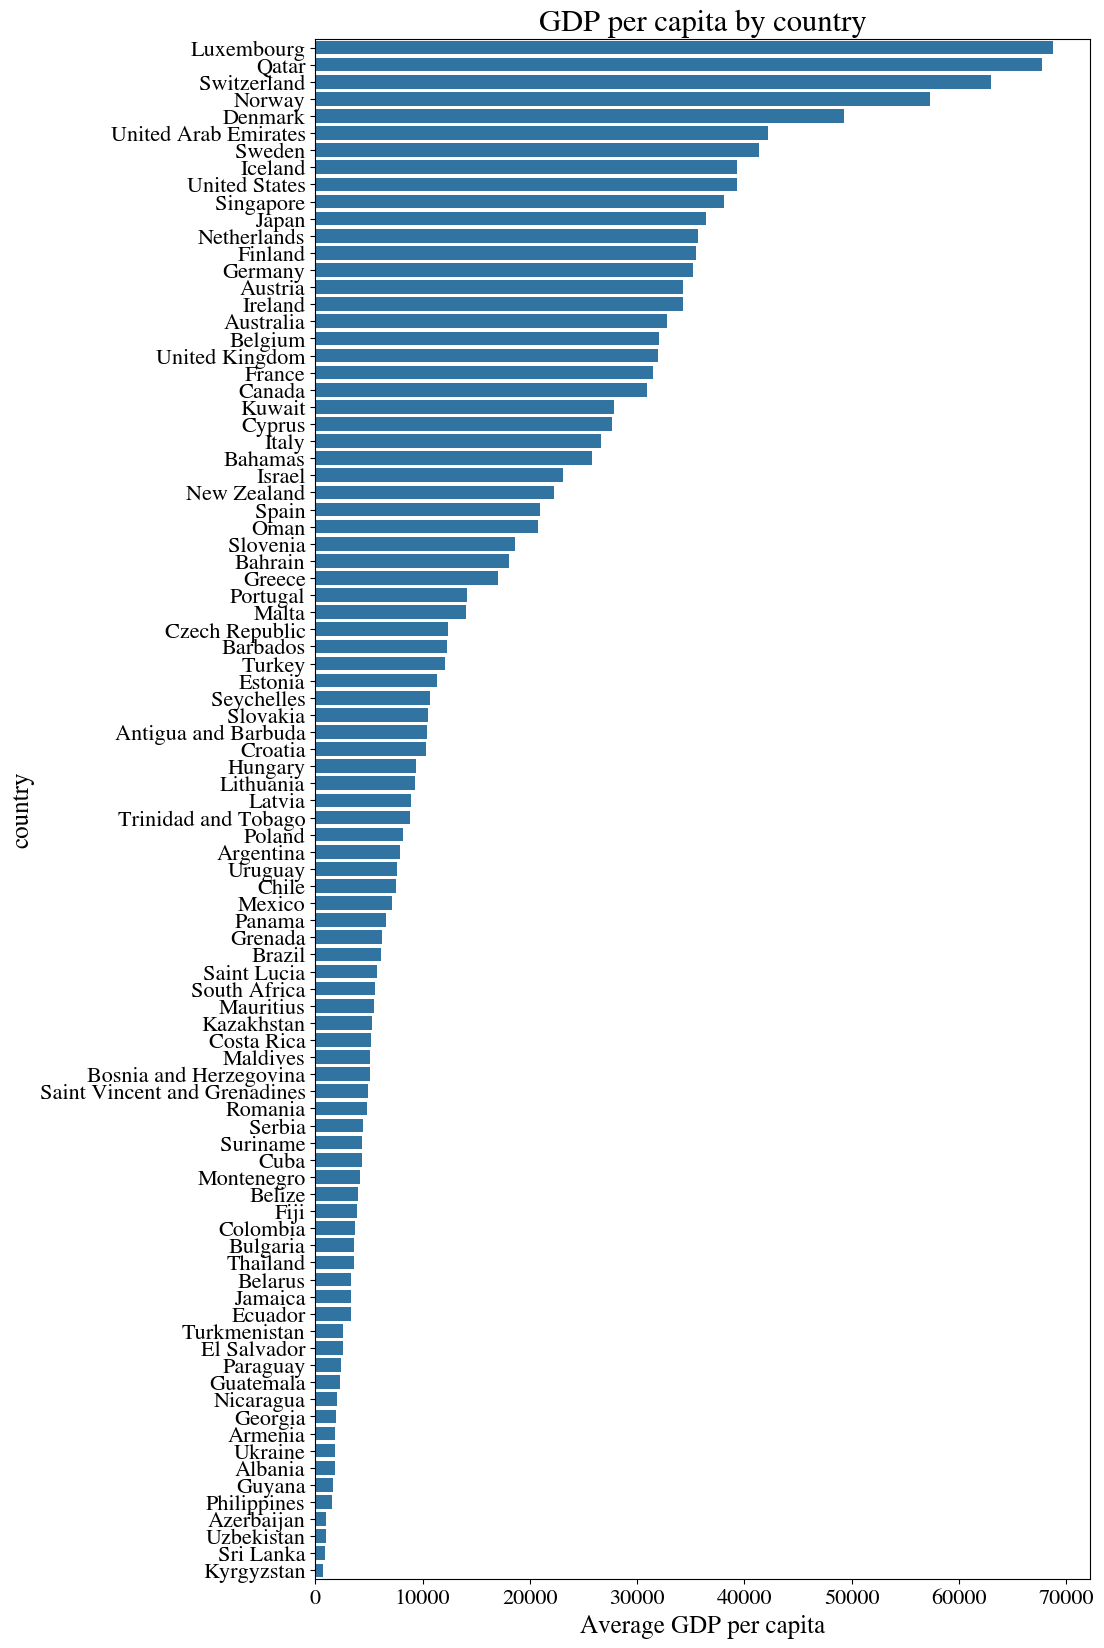

In [21]:
# Plot of the GDP per capita average for each country
average_country_gdp_pc = suicides.groupby("country").gdp_per_capita.mean().sort_values(ascending=False)
plt.figure(figsize=(6, 6))
sns.barplot(average_country_gdp_pc[:10], orient="h")
plt.xlabel("Average GDP per capita")
plt.title("GDP per capita by country")
plt.show()

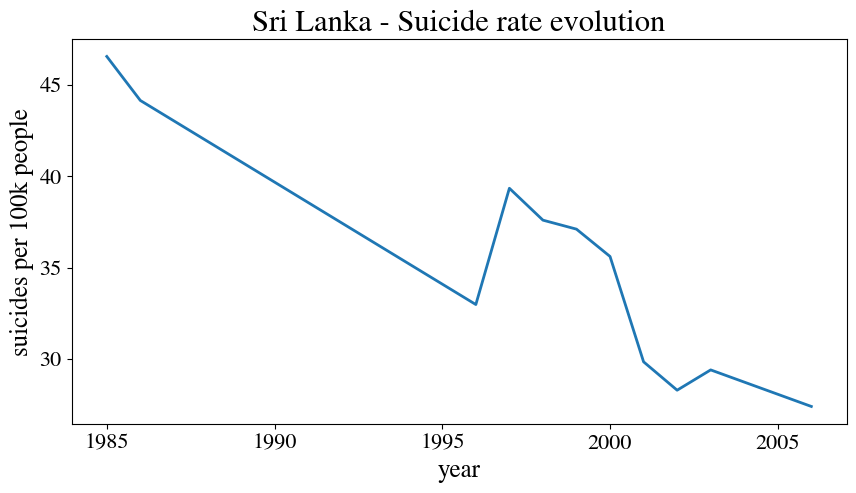

In [22]:
# Sri Lanka Average suicide rates evolution throught time
sri_lanka_suicides_by_year = suicides[suicides["country"] == "Sri Lanka"].groupby("year").suicides_rate.mean()
sns.lineplot(sri_lanka_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Sri Lanka - Suicide rate evolution");

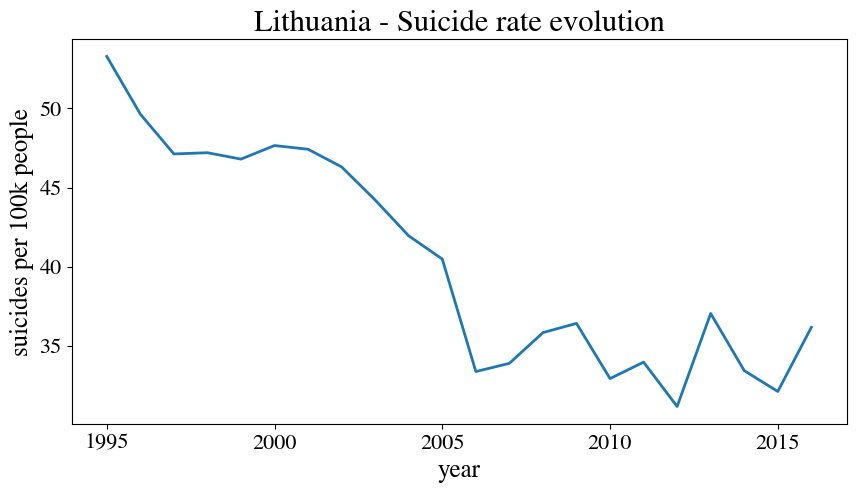

In [23]:
# Lithuania Average suicide rates evolution throught time
lithuania_suicides_by_year = suicides[suicides["country"] == "Lithuania"].groupby("year").suicides_rate.mean()
sns.lineplot(lithuania_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Lithuania - Suicide rate evolution");

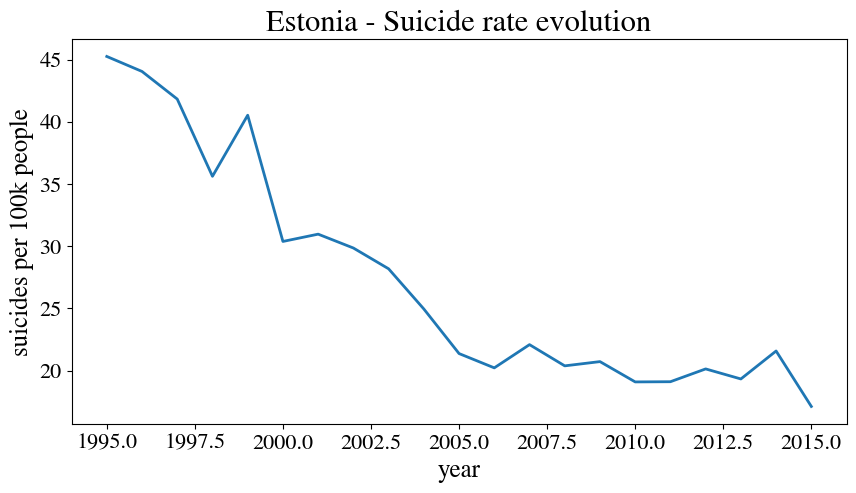

In [24]:
# Estonia Average suicide rates evolution throught time
estonia_suicides_by_year = suicides[suicides["country"] == "Estonia"].groupby("year").suicides_rate.mean()
sns.lineplot(estonia_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Estonia - Suicide rate evolution");

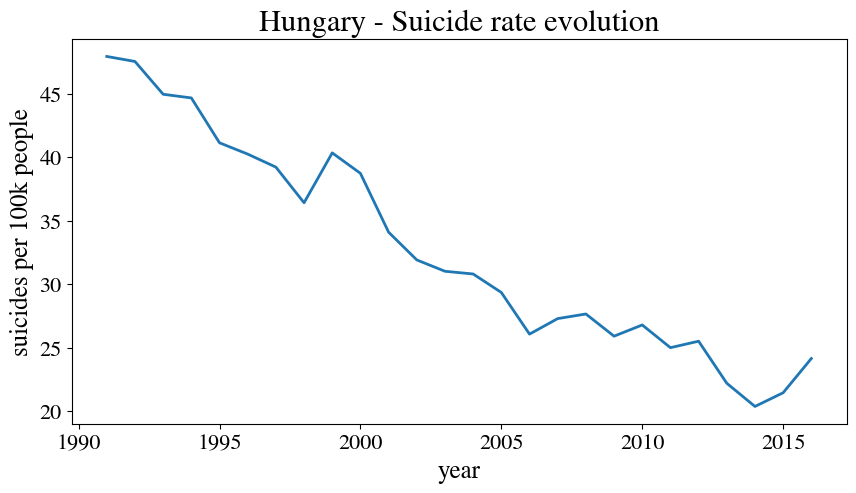

In [25]:
# Hungary Average suicide rates evolution throught time
hungary_suicides_by_year = suicides[suicides["country"] == "Hungary"].groupby("year").suicides_rate.mean()
sns.lineplot(hungary_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Hungary - Suicide rate evolution");

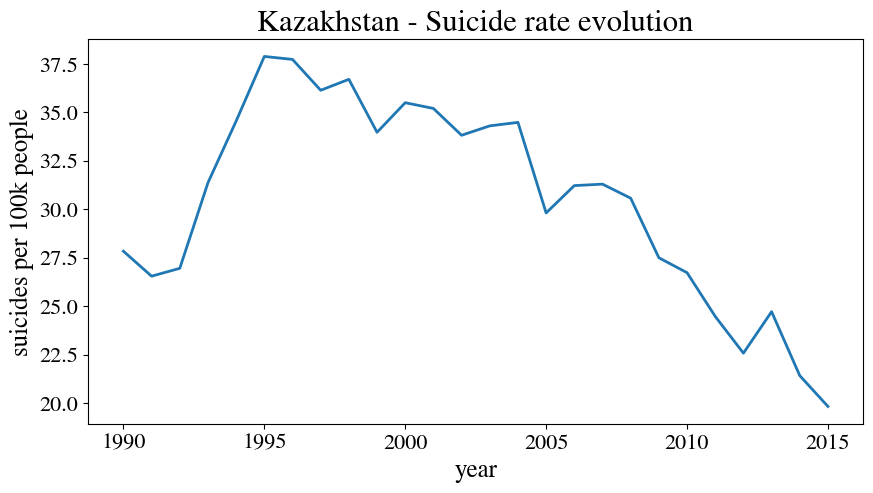

In [26]:
# Kazakhstan Average suicide rates evolution throught time
kazakh_suicides_by_year = suicides[suicides["country"] == "Kazakhstan"].groupby("year").suicides_rate.mean()
sns.lineplot(kazakh_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Kazakhstan - Suicide rate evolution");

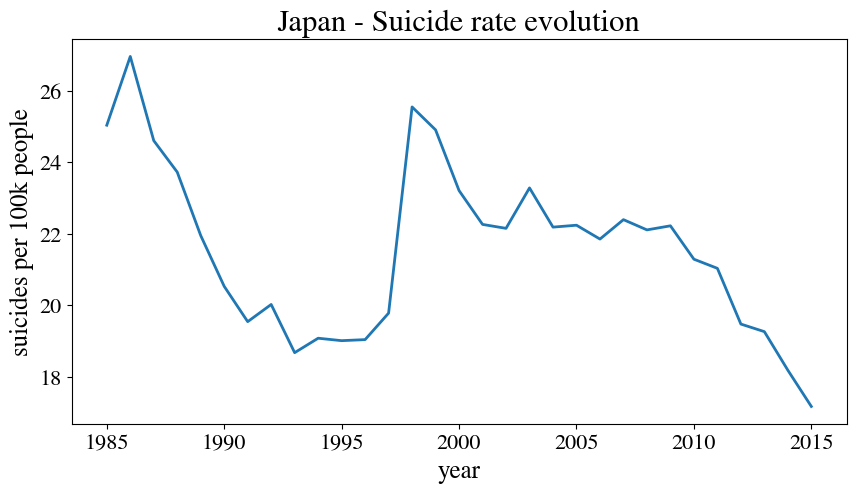

In [27]:
# Japan Average suicide rates evolution throught time
japan_suicides_by_year = suicides[suicides["country"] == "Japan"].groupby("year").suicides_rate.mean()
sns.lineplot(japan_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Japan - Suicide rate evolution");

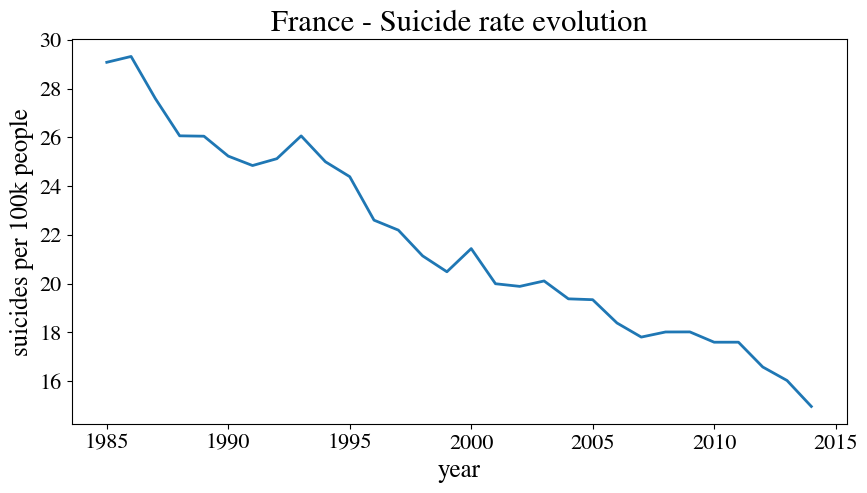

In [28]:
# France Average suicide rates evolution throught time
france_suicides_by_year = suicides[suicides["country"] == "France"].groupby("year").suicides_rate.mean()
sns.lineplot(france_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("France - Suicide rate evolution");

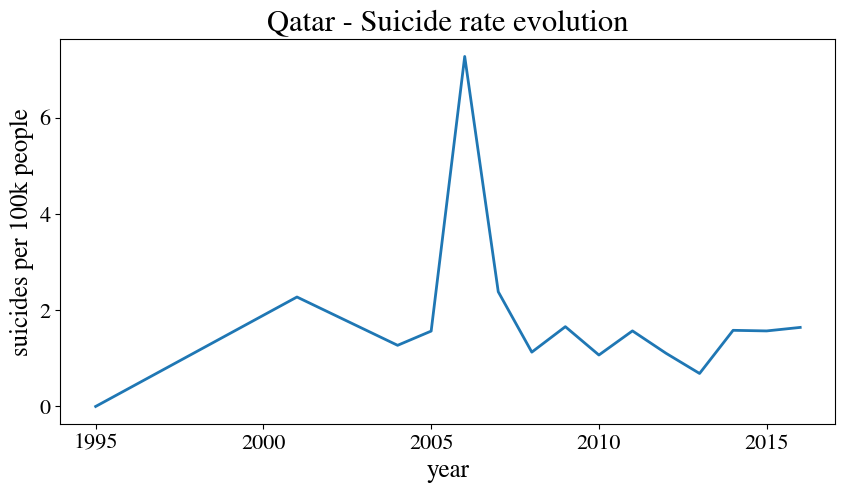

In [29]:
# Qatar Average suicide rates evolution throught time
qatar_suicides_by_year = suicides[suicides["country"] == "Qatar"].groupby("year").suicides_rate.mean()
sns.lineplot(qatar_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Qatar - Suicide rate evolution");

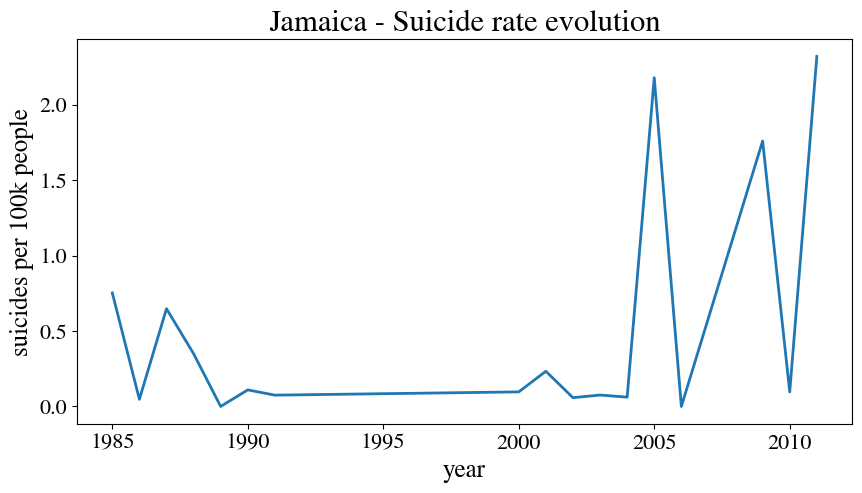

In [30]:
# Jamaica Average suicide rates evolution throught time
jamaica_suicides_by_year = suicides[suicides["country"] == "Jamaica"].groupby("year").suicides_rate.mean()
sns.lineplot(jamaica_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Jamaica - Suicide rate evolution");

> Let us now study the average suicide rate per year. <br>
> Just for understanding, we will plot the number of suicides across year first to make some insights.

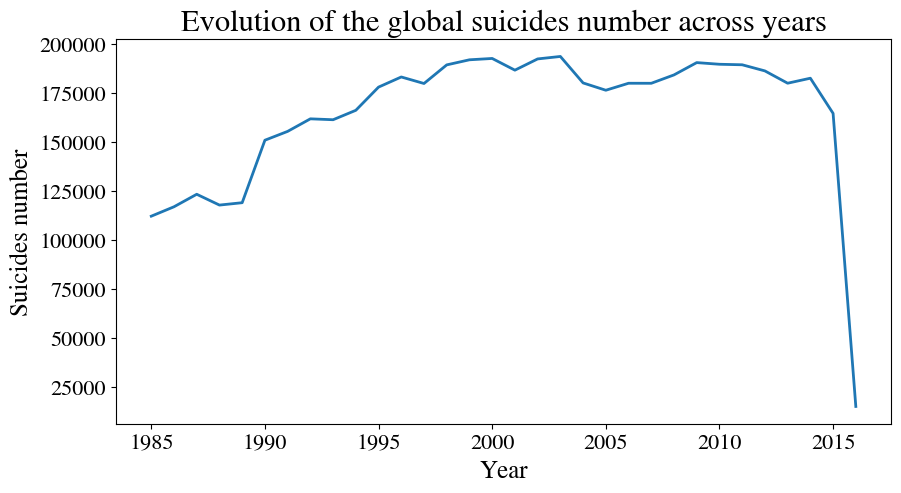

In [31]:
# Global suicides number across years in the dataframe
plt.plot(suicides.groupby('year').sum()['suicides_no'])
plt.xlabel('Year')
plt.ylabel('Suicides number')
plt.title('Evolution of the global suicides number across years');

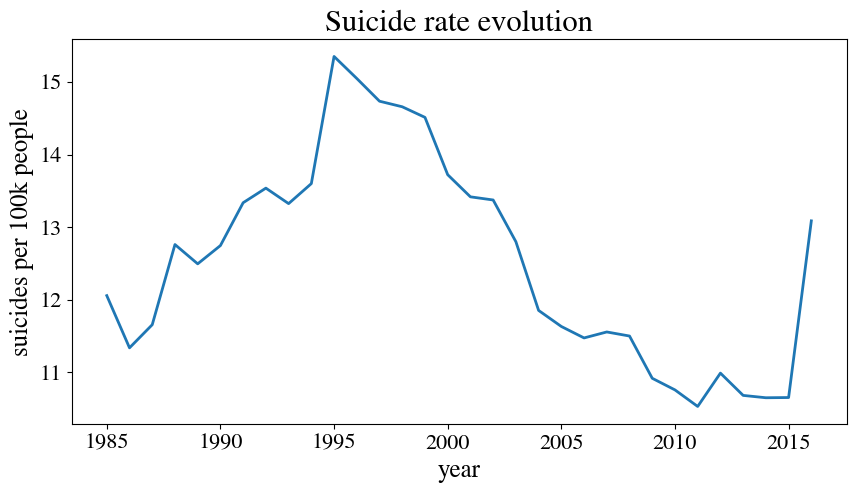

In [32]:
# Plot of the suicide rate evolution across years
suicides_by_year = suicides.groupby("year").suicides_rate.mean()
sns.lineplot(suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Suicide rate evolution");

> Suicide rate went from about 12 suicides per 100k people in 1985 to a peak in 1995 at more than 15. This might seem strange at first glance but could actually be explained by the high level of mental distress an economical instability of the time ([see the events of 1995](https://en.wikipedia.org/wiki/1995#Events)). <br>
We can also study the number of suicides depending on some variables about the individuals such as sex or age category.

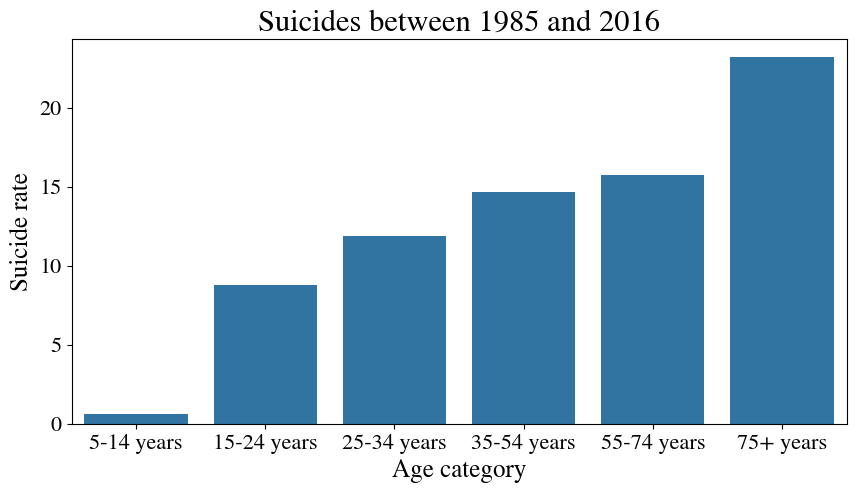

In [33]:
# Plot of the suicides rate for each age category
age_count = suicides.groupby("age").suicides_rate.mean()
sns.barplot(age_count)
plt.xticks(range(len(age_map)), labels=list(age_map.keys()))
plt.xlabel("Age category")
plt.ylabel("Suicide rate")
plt.title("Suicides between 1985 and 2016")
plt.show()

> Most suicides occur when people are between 35 and 54 years, which could be explained by their work and the fact that they start getting older.

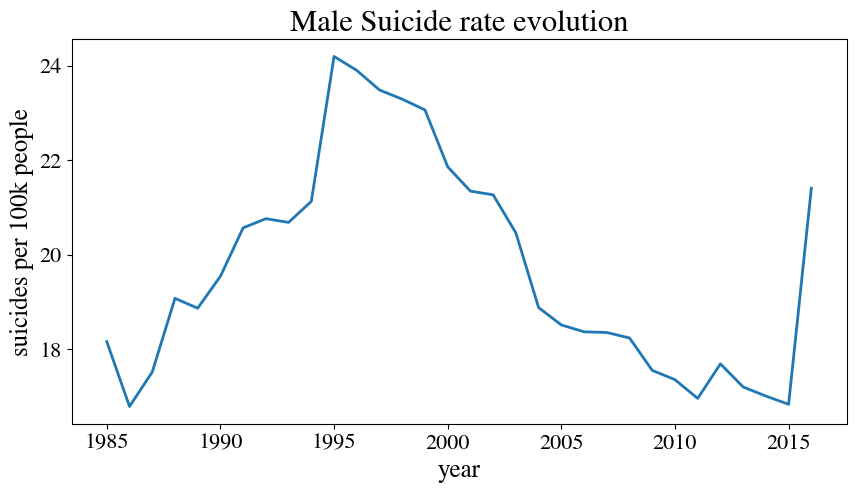

In [34]:
# Male Average suicide rates evolution throught time
male_suicides_by_year = suicides[suicides["sex"] == "male"].groupby("year").suicides_rate.mean()
sns.lineplot(male_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Male Suicide rate evolution");

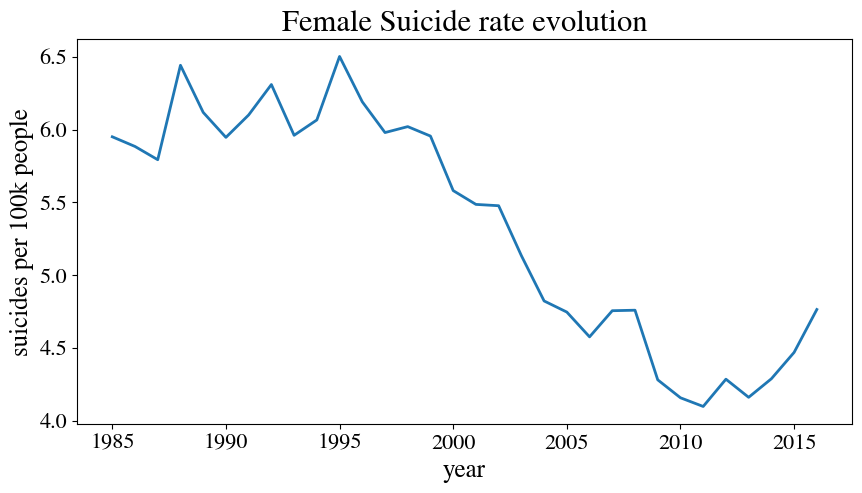

In [35]:
# Female Average suicide rates evolution throught time
female_suicides_by_year = suicides[suicides["sex"] == "female"].groupby("year").suicides_rate.mean()
sns.lineplot(female_suicides_by_year)
plt.xlabel("year")
plt.ylabel("suicides per 100k people")
plt.title("Female Suicide rate evolution");

In [36]:
# Average of male suicide rate
male_a = male_suicides_by_year.mean()
print(f"Male suicide rate: {male_a:.2f} suicides/100k")

# Average of female suicide rate
female_a = female_suicides_by_year.mean()
print(f"Male suicide rate: {female_a:.2f} suicides/100k")

Male suicide rate: 19.70 suicides/100k
Male suicide rate: 5.35 suicides/100k


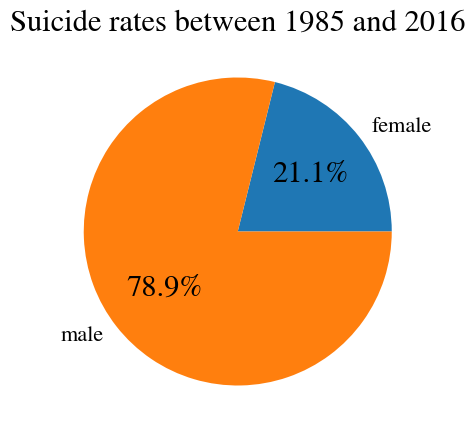

In [37]:
# Plot of the proportion of male suicides vs female suicides
sex_count = suicides.groupby("sex").suicides_rate.mean()
plt.pie(sex_count.values, labels=sex_count.index, autopct="%1.1f%%")
plt.title("Suicide rates between 1985 and 2016")
plt.show()

> Most suicides are commited by men. In fact, most of the attempts are done by females, but they more rarely lead to death. Men tend to chose more violent and "effective" ways of commiting suicide and are less prone to seeking help ([source](https://en.wikipedia.org/wiki/Gender_differences_in_suicide)). <br>
Let us now focus on GPD and HDI.

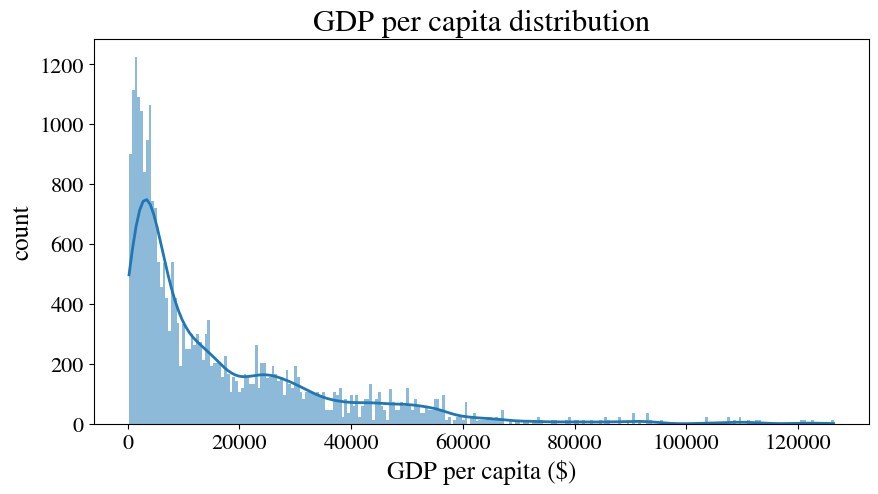

In [38]:
# Distribution of the gdp per capita
sns.histplot(suicides.gdp_per_capita, kde=True, binwidth=500, ec=None)
plt.title("GDP per capita distribution")
plt.xlabel("GDP per capita ($)")
plt.ylabel("count");

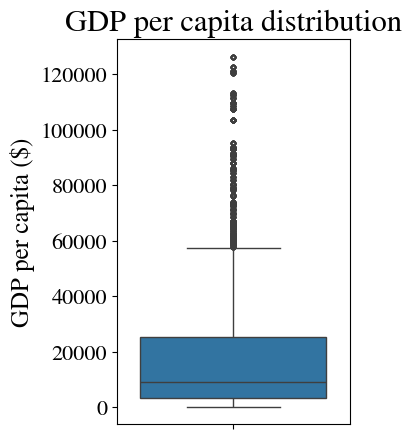

In [39]:
# Plot of the boxplot of the GDP per capita
plt.figure(figsize=(3, 5))
sns.boxplot(suicides.gdp_per_capita)
plt.title("GDP per capita distribution")
plt.ylabel("GDP per capita ($)");

> Without surprise, most countries have a low GPD per capita and only few of them have a high one.

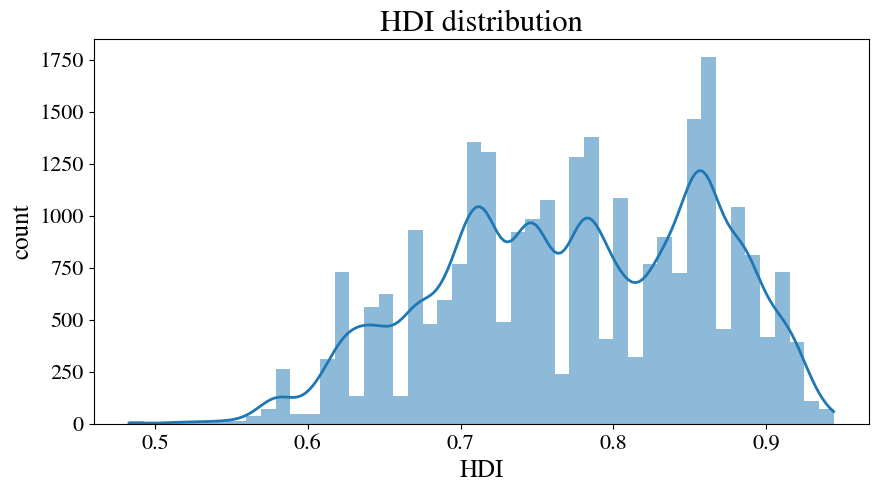

In [40]:
# Distribution of the hdi
sns.histplot(suicides.hdi, kde=True, ec=None)
plt.title("HDI distribution")
plt.xlabel("HDI")
plt.ylabel("count");

Text(0, 0.5, 'HDI')

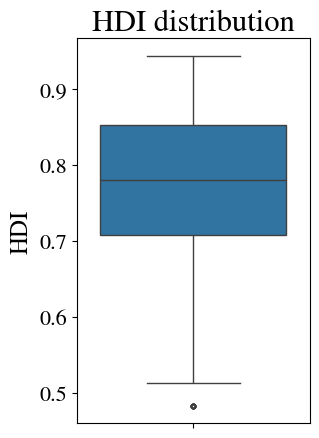

In [41]:
# Plot of the boxplot of the HDI (Human Development Index)
plt.figure(figsize=(3, 5))
sns.boxplot(suicides.hdi)
plt.title("HDI distribution")
plt.ylabel("HDI")

> As we can seen, the HDI is contained between 0.5 and 1 and the average HDI is about 0.8. Let us try to corellate the GDP and the HDI to the suicide rate.

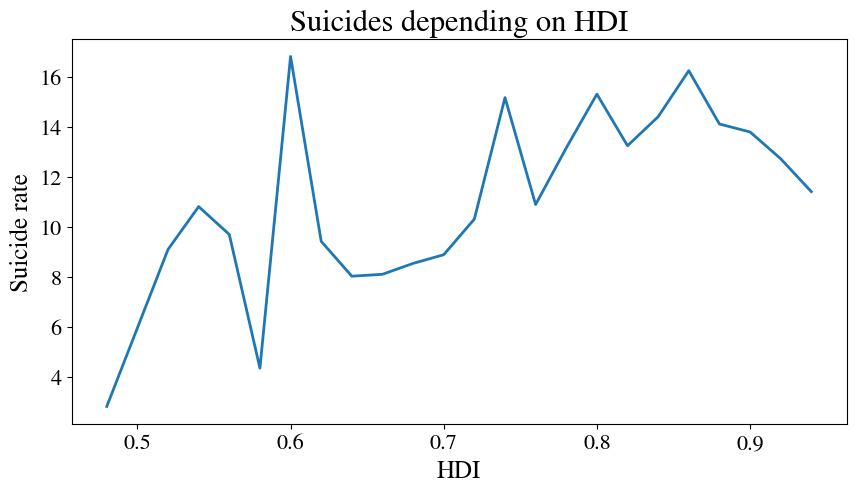

In [42]:
# Plot of the suicide rate vs the HDI
hdi_resolution = 50
suicides["hdi_category"] = suicides.hdi.map(lambda x: round(x*hdi_resolution)/hdi_resolution)
sns.lineplot(suicides.groupby("hdi_category").suicides_rate.mean())
plt.title("Suicides depending on HDI")
plt.xlabel("HDI")
plt.ylabel("Suicide rate");

> Apparently, there is no linear relationship between the HDI and the suicide rate, as we could have expected. In fact, it even seems that the higher the HDI is, the higher the suicide rate tends to be, except a very high suicide rate for a HDI at about 0.6.

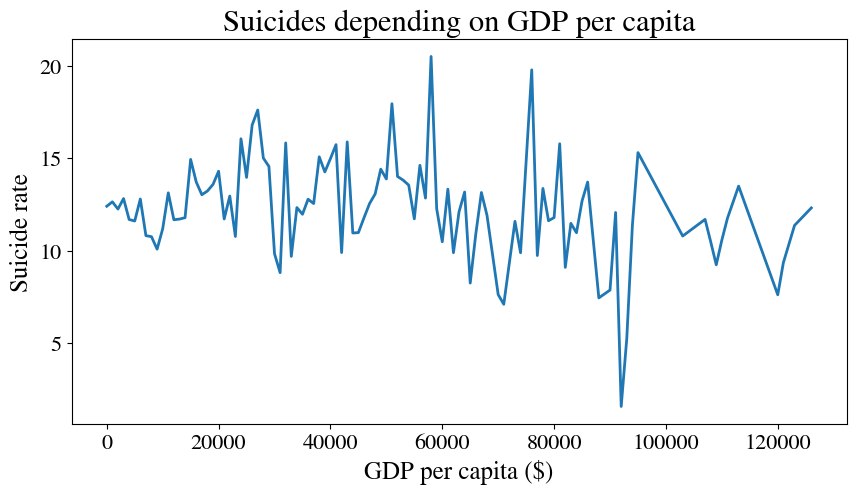

In [43]:
# Plot of the suicide rate vs the GDP per capita
gdp_per_capita_resolution = .001
suicides["gdp_per_capita_category"] = suicides.gdp_per_capita.map(lambda x: round(x*gdp_per_capita_resolution)/gdp_per_capita_resolution)
sns.lineplot(suicides.groupby("gdp_per_capita_category").suicides_rate.mean())
plt.title("Suicides depending on GDP per capita")
plt.xlabel("GDP per capita ($)")
plt.ylabel("Suicide rate");

> There is no clear relationship between the GDP per capita and the average suicide rate.

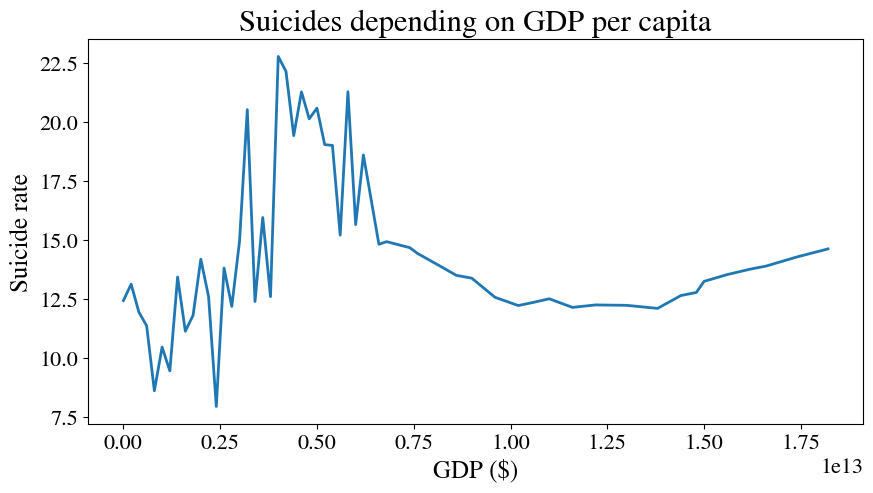

In [44]:
# Plot of the suicide rate vs the GDP for a country
gdp_resolution = 0.000000000005
suicides["gdp_category"] = suicides.gdp.map(lambda x: round(x*gdp_resolution)/gdp_resolution)
sns.lineplot(suicides.groupby("gdp_category").suicides_rate.mean())
plt.title("Suicides depending on GDP per capita")
plt.xlabel("GDP ($)")
plt.ylabel("Suicide rate");

> On the other hand, GDP seems to have a direct link with the suicide rate in the country. Very low GDP generaly lead to quite low suicide rate. Medium GDP countries record the highest suicide rates. And the suicide rates of high GDP countries are relatively average and stable. 

> Let us now evaluate statistically the correlation between the GDP and the suicide rate as well as the HDI and the suicide rate.

In [45]:
# Correlation test between 'hdi' and 'suicide_rate'
corr, p_value = pearsonr(suicides['hdi'], suicides['suicides_rate'])
print(f"Correlation between 'hdi' and 'suicide_rate': {corr:.4f}, p-value: {p_value:.2e}")

# Correlation test between 'gdp' and 'suicide_rate'
corr, p_value = pearsonr(suicides['gdp'], suicides['suicides_rate'])
print(f"Correlation between 'gdp' and 'suicide_rate': {corr:.4f}, p-value: {p_value:.2e}")

# Correlation test between 'gdp_per_capita' and 'suicide_rate'
corr, p_value = pearsonr(suicides['gdp_per_capita'], suicides['suicides_rate'])
print(f"Correlation between 'gdp_per_capita' and 'suicide_rate': {corr:.4f}, p-value: {p_value:.2e}")

Correlation between 'hdi' and 'suicide_rate': 0.1163, p-value: 6.38e-80
Correlation between 'gdp' and 'suicide_rate': 0.0193, p-value: 1.73e-03
Correlation between 'gdp_per_capita' and 'suicide_rate': 0.0097, p-value: 1.14e-01


In [46]:
# Correlation test between 'hdi' and 'suicide_rate'
corr, p_value = spearmanr(suicides['hdi'], suicides['suicides_rate'])
print(f"Correlation between 'hdi' and 'suicide_rate': {corr:.4f}, p-value: {p_value:.2e}")

# Correlation test between 'gdp' and 'suicide_rate'
corr, p_value = spearmanr(suicides['gdp'], suicides['suicides_rate'])
print(f"Correlation between 'gdp' and 'suicide_rate': {corr:.4f}, p-value: {p_value:.2e}")

# Correlation test between 'gdp_per_capita' and 'suicide_rate'
corr, p_value = spearmanr(suicides['gdp_per_capita'], suicides['suicides_rate'])
print(f"Correlation between 'gdp_per_capita' and 'suicide_rate': {corr:.4f}, p-value: {p_value:.2e}")

Correlation between 'hdi' and 'suicide_rate': 0.1859, p-value: 2.52e-203
Correlation between 'gdp' and 'suicide_rate': 0.2214, p-value: 9.93e-290
Correlation between 'gdp_per_capita' and 'suicide_rate': 0.0783, p-value: 4.41e-37


In [47]:
# Correlation test between 'hdi' and 'suicide_rate'
corr, p_value = kendalltau(suicides['hdi'], suicides['suicides_rate'])
print(f"Correlation between 'hdi' and 'suicide_rate': {corr:.4f}, p-value: {p_value:.2e}")

# Correlation test between 'gdp' and 'suicide_rate'
corr, p_value = kendalltau(suicides['gdp'], suicides['suicides_rate'])
print(f"Correlation between 'gdp' and 'suicide_rate': {corr:.4f}, p-value: {p_value:.2e}")

# Correlation test between 'gdp_per_capita' and 'suicide_rate'
corr, p_value = kendalltau(suicides['gdp_per_capita'], suicides['suicides_rate'])
print(f"Correlation between 'gdp_per_capita' and 'suicide_rate': {corr:.4f}, p-value: {p_value:.2e}")

Correlation between 'hdi' and 'suicide_rate': 0.1209, p-value: 1.20e-185
Correlation between 'gdp' and 'suicide_rate': 0.1482, p-value: 2.01e-279
Correlation between 'gdp_per_capita' and 'suicide_rate': 0.0509, p-value: 1.58e-34


> In contrast to everything we have observed previously, the statistical tests here reveal that the correlation between the variable of suicide rate ('suicide_rate') and the three other variables, namely 'hdi,' 'gdp,' and 'gdp_per_capita' (representing the Human Development Index, GDP, and GDP per 100,000 inhabitants, respectively), is null. Additionally, the p-value is significantly low for all these statistical tests. This would imply that our variables are statistically unrelated; they are significantly decorrelated. This result is entirely logical in light of the trend in the curve connecting each of the three variables to the suicide rate. Indeed, these curves, consistently noisy as previously noted, would be the cause of statistical decorrelation. However, the overall trend curve of the average noisy values visually shows that there is a connection. This connection evidently depends on other parameters that obscure the trajectory, but a connection exists! This is what we will try to further investigate through our models. We will attempt to assess the relevance of the influence of these economic variables on the overall evolution of the global suicide rate. The results will allow us to draw conclusions about all the observations and analyses made throughout this section. Now, let's move on to the exploratory analysis of the second database that we will combine with the suicide data!

### 2. Gender wage gap
> An essential point to raise is that, as we have seen previously, women and men do not have exactly the same suicide rate. While women tend to attempt suicide more often than men (Source: [Wikipedia](https://en.wikipedia.org/wiki/Gender_differences_in_suicide)), it is men who have the highest suicide rate. This is attributed to their more violent and therefore more effective suicide methods compared to women.

> One might be tempted to ask why women attempt suicide more often. Could this result help us find a significant factor for the economic explanation of a country's suicide rate ? <br> Indeed, several reasons could explain the higher number of attempts. Some may point to more significant mood disorders in women than men, but this is highly subjective. Others might argue that it is related to social roles and the pressure associated with those roles. This reason seems more relevant, as per an INSEE report (Source: [INSEE Report](https://www.insee.fr/fr/statistiques/6047741?sommaire=6047805#:~:text=Par%20rapport%20aux%20hommes%2C%20les%20femmes%20d%C3%A9clarent%20moins,correctement%20leur%20travail%2C%20contre%2022%20%25%20des%20hommes)), which states that: "Compared to men, women report less lack of support from their superiors, but they are, however, slightly more likely to declare not receiving the respect and esteem their work deserves." In other words, women are not entirely satisfied with the recognition they receive in the workplace: Dissatisfaction that could unfortunately impact various other aspects of their lives.

> Thus, it seems that the real avenue here to try and identify a new factor for suicide rates could be gender inequality. Some countries with significantly skewed gender ratios, with more women than men, might experience an increase in suicide rates. To incorporate this into our analysis, we have added a new dataset, which we are merging with the basic suicide dataset to integrate this information. However, the analysis is more focused on gender wage disparities as a new variable that could influence our dataset. As we already highlighted, the dataset is sourced from [OECD] and was retrieved from [this link](https://data.oecd.org/earnwage/gender-wage-gap.htm). Let's dive now into the data exploration.

In [48]:
# Load gender gap dataset
gender = pd.read_csv(DATAPATH + "gender_gap.csv")

In [49]:
# Dimension of the dataset
print(f"Dataset dimensions: {gender.shape[0]} × {gender.shape[1]}")

Dataset dimensions: 1350 × 8


In [50]:
# Random lines of our dataframe
gender.sample(5, random_state=SEED)

LOCATION INDICATOR   SUBJECT MEASURE FREQUENCY  TIME      Value  \
289       FIN   WAGEGAP  EMPLOYEE      PC         A  2002  20.373203   
1036      USA   WAGEGAP  EMPLOYEE      PC         A  1978  38.972477   
535       JPN   WAGEGAP  EMPLOYEE      PC         A  2003  31.997350   
346       DEU   WAGEGAP  EMPLOYEE      PC         A  2003  19.820538   
1075      USA   WAGEGAP  EMPLOYEE      PC         A  2017  18.172157   

     Flag Codes  
289         NaN  
1036        NaN  
535         NaN  
346         NaN  
1075        NaN

In [51]:
# The different variables of our dataset
print_list(gender.columns, "Variables in dataset")

Variables in dataset:
  • LOCATION
  • INDICATOR
  • SUBJECT
  • MEASURE
  • FREQUENCY
  • TIME
  • Value
  • Flag Codes


> The dataset here contains 1350 instances and 8 variables which are :
> - `LOCATION`: the country code
> - `INDICATOR`: an indicator which is always `"wageGAP"` (useless variable that we will remove during data preparation).
> - `SUBJECT`: a subject which is either `"EMPLOYEE"` or `"SELFEMPLOYED"`
> - `MEASURE`: a measure which is always `"PC"` (useless variable that we will remove during data preparation).
> - `TIME`: the year of a record, ranging from 1970 to 2022. 
> - `FREQUENCY`: a frequency value which is always `"A"` (useless variable that we will remove during data preparation).
> - `Value`: the gender wage gap, in percents. 
> - `Flag Codes`: a flag which is always `NaN` or `B`, (useless variable that we will remove during data preparation).

#### 2.1. Data preparation for gender gap
> In this section, we will try to exclude useless variables and outliers, remove `NaN`s and more generaly make the data easier to work with. <br>
First of all, some of the variable names used in the original dataset do not respect snake case, so we will rename them for ease of use.

In [52]:
columns_rename_map = {
    "LOCATION": "country",
    "SUBJECT": "employment",
    "TIME": "year",
    "Value": "gap",
}

gender.rename(columns_rename_map, axis=1, inplace=True);

> Now we can drop useless columns.

In [53]:
gender.drop(["INDICATOR", "MEASURE", "FREQUENCY", "Flag Codes"], axis=1, inplace=True)

> As shown by the following cell, there is no missing data in the resulting dataset.

In [54]:
for variable in gender.columns:
    try:
        print(f"{gender[variable].value_counts(normalize=True, dropna=False)[np.nan]*100:.1f}% of values are missing for variable {variable}.")
    except KeyError:
        print(f"No nan value for variable {variable}.")

No nan value for variable country.
No nan value for variable employment.
No nan value for variable year.
No nan value for variable gap.


> Next, the countries are identified by their code. To be able to work with the suicides dataset, we need to convert these codes to the full country names. We could have used python libraries such as `country_converter` or `pycountry`, but due to the small number of convertions we need to do, it would be inefficient to install such libraries. We will instead use a simple mapping, constructed by hand.

In [55]:
country_code_to_name = {
    "AUS": "Australia",
    "AUT": "Austria",
    "BEL": "Belgium",
    "CAN": "Canada",
    "CZE": "Czech Republic",
    "DNK": "Danemark",
    "FIN": "Finland",
    "FRA": "France",
    "DEU": "Germany",
    "GRC": "Greece",
    "HUN": "Hungary",
    "ISL": "Iceland",
    "IRL": "Ireland",
    "ITA": "Italia",
    "JPN": "Japan",
    "KOR": "Korea",
    "LUX": "Luxembourg",
    "MEX": "Mexico",
    "NLD": "Netherlands",
    "NZL": "New Zealand",
    "NOR": "Norway",
    "POL": "Poland",
    "PRT": "Portugal",
    "SVK": "Slovakia",
    "ESP": "Spain",
    "SWE": "Sweden",
    "CHE": "Switzerland",
    "TUR": "Turkey",
    "GBR": "United Kingdom",
    "USA": "United States",
    "BGR": "Bulgaria",
    "CHL": "Chile",
    "COL": "Colombia",
    "CRI": "Costa Rica",
    "HRV": "Croatia",
    "CYP": "Cyprus",
    "EST": "Estonia",
    "ISR": "Israel",
    "LVA": "Latvia",
    "LTU": "Lithuania",
    "MLT": "Malta",
    "ROU": "Romania",
    "SVN": "Slovenia",
    "OECD": "International", # Not a country
    "EU27": "European Union", # Not a country
    "ARG": "Argentina",
    "BRA": "Brazil",
}
gender["country"] = gender.country.map(country_code_to_name)

#### 2.2. Data visualization of gender gap dataset
> One of the first things we can plot is the average wage gap per year and try to detect a trend.

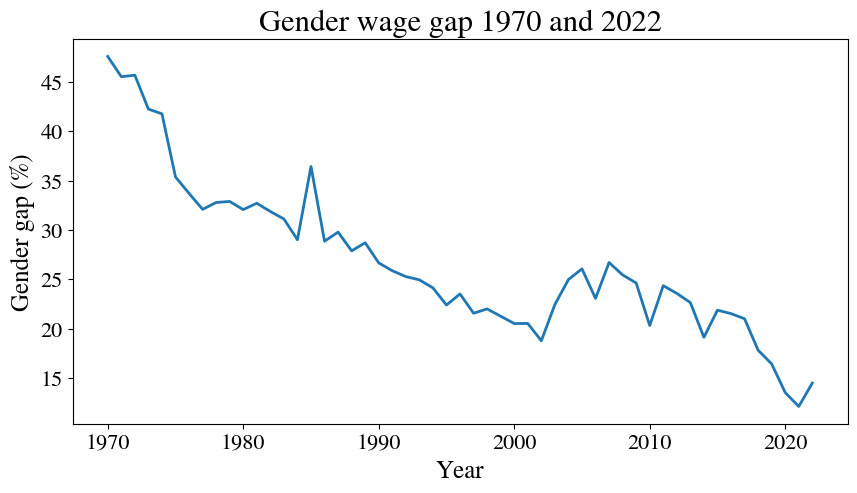

In [56]:
gap_by_year = gender.groupby("year").gap.mean()
sns.lineplot(gap_by_year)
plt.xlabel("Year")
plt.ylabel("Gender gap (%)")
plt.title("Gender wage gap 1970 and 2022");

> As we could have expected, the gender wage gap has highly decreased in the past decades. Surpisingly, we note that it increased between 2002 and 2005, but kept decreasing after that. <br>
Now we can also visualize the average gender gap depending on the country since 1970.

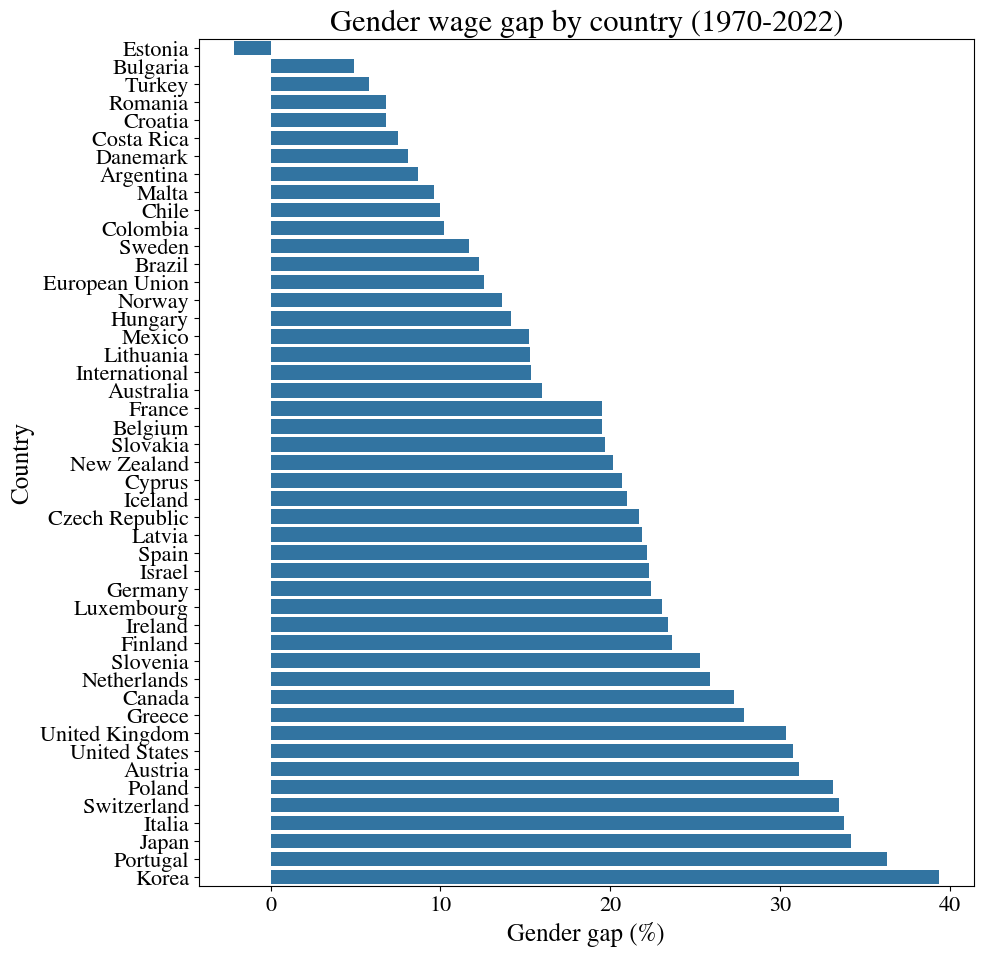

In [57]:
average_country_gap = gender.groupby("country").gap.mean().sort_values()
plt.figure(figsize=(10, 11))
sns.barplot(average_country_gap, orient="h")
plt.xlabel("Gender gap (%)")
plt.ylabel("Country")
plt.title("Gender wage gap by country (1970-2022)");

> Countries with the bigest country gap are:
> - Korea
> - Portugal
> - Japan
>
> And the lowest gaps are found in:
> - Estonia
> - Bulgaria
> - Turkey
>
> As we can see from these first results, the country developement is not directly responsible for the gender wage gap in that country. The lowest gender gap is met in Estonia, where it even is negative (on average, women earn more than men). Estonia is the only country that has a negative average gender gap, that is that in all other countries, men tend to earn more than women. <br>
We can also note that the European Union (denoted by `EU27`) has a gender gap slighly below the average. <br>
But this is the average gender gap since 1970 and might not be representative of the recent data. We will plot the same data, but restrict the year between 2017 and 2022 in order to get a better representation of what the gender gap is currently.

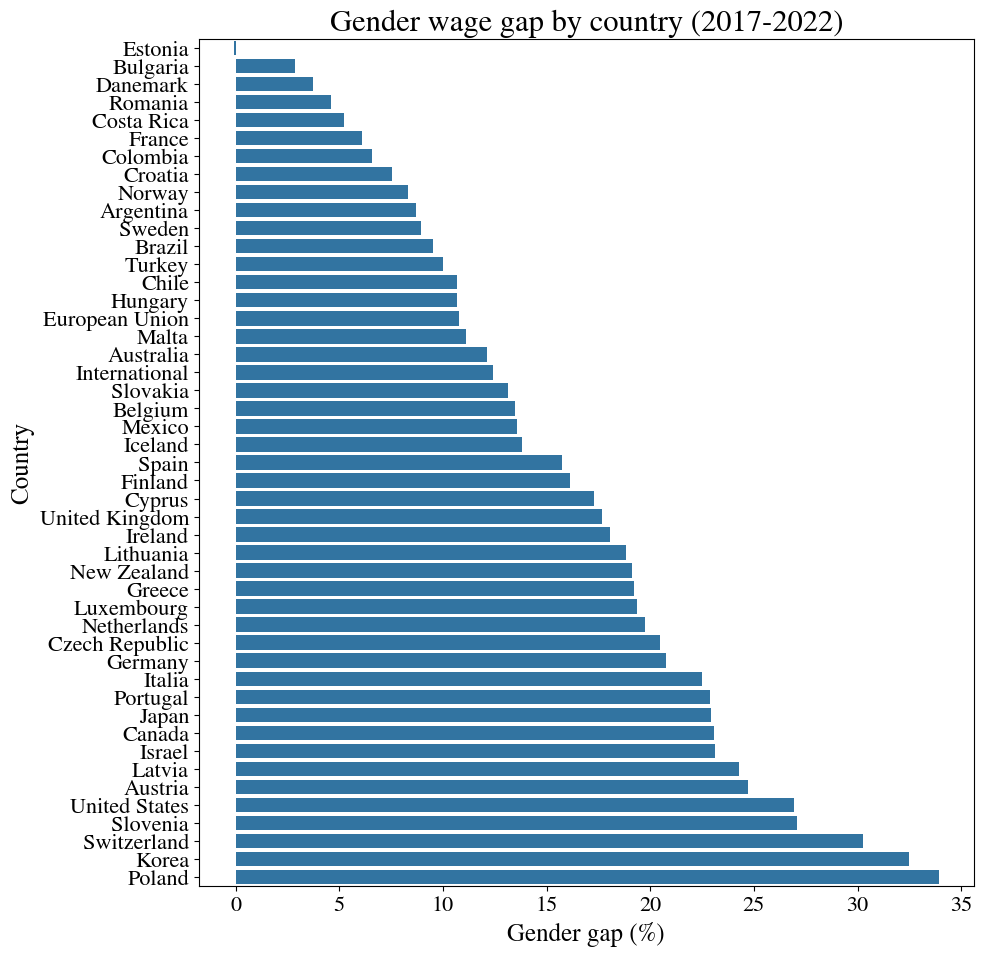

In [58]:
recent_average_country_gap = gender[gender.year>=2017].groupby("country").gap.mean().sort_values()
plt.figure(figsize=(10, 11))
sns.barplot(recent_average_country_gap, orient="h")
plt.xlabel("Gender gap (%)")
plt.ylabel("Country")
plt.title("Gender wage gap by country (2017-2022)");

> This does not have a really big impact on the data, except that now most countries with a low gender wage gap are european. The country with the bigest gender gap is now Poland, but Korea still has a very high gender gap. <br>
Note that the gender gap is globaly lower in the last 5 years than since 1970, which is confirmed by the first plot of this section. <br>
Another interesting variable to take in acount is the type of employement. We expect self-employed people to met a lower gender wage gap since they are paying themselves, but we can verify this hypothesis with the following chart.

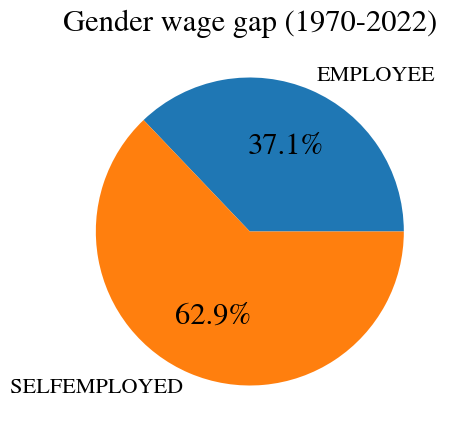

In [59]:
employement_gap = gender.groupby("employment").gap.mean()
plt.pie(employement_gap.values, labels=employement_gap.index, autopct="%1.1f%%")
plt.title("Gender wage gap (1970-2022)");

> Strangely, self-employed people face a higher gender gap than employed people. This is becaused most self-employed women tend to charge less than self-employed men, leading to a lower wage and most self-employed workers are small companies ([source](https://theconversation.com/gender-pay-gap-is-bigger-for-some-women-than-others-heres-how-to-work-it-out-199473)).

### 3. Preparation of the full dataframe

> In this section, we combine both datasets in a single dataframe, that we will later use in our model. <br>
> The decision has been made to group data by year and by country. Since the data changes a lot through time (especialy the gender wage gap) and geography, this ensures we keep important variables in our data, but ignore factors that might introduce too much complexity and less revelant information. <br>
We also need to choose the variables we will keep in this final dataframe. Given our previous analysis and our goal, we choose to keep the following variables:
> - `year`
> - `country`
> - `suicides_rate` (the average suicide rate)
> - `gdp`
> - `gdp_per_capita`
> - `hdi`
> - `gap` (the gender wage gap)
>
> Note that some countries included in the suicide rates dataset are not present in the gender wage gap dataset. We will ignore those countries in the rest of our study, keeping the 47 countries already included in the gender gap dataset, which is already enough for our analysis.

In [60]:
left = pd.DataFrame() # left dataframe for the following join operation
left["suicides_rate"] = suicides.groupby(["year", "country"]).suicides_rate.mean()
left["gdp"] = suicides.groupby(["year", "country"]).gdp.mean()
left["gdp_per_capita"] = suicides.groupby(["year", "country"]).gdp_per_capita.mean()
left["hdi"] = suicides.groupby(["year", "country"]).hdi.mean()
left = left.reset_index()

right = pd.DataFrame() # right dataframe for the following join operation
right = gender.groupby(["year", "country"]).gap.mean()

data = pd.merge(
    left,
    right, 
    "inner",
    ["year", "country"]
)

In [61]:
print(f"Data shape: {data.shape[0]}×{data.shape[1]}")
data.sample(5, random_state=SEED)

Data shape: 604×7


year        country  suicides_rate           gdp  gdp_per_capita  \
110  1999         Canada      13.203333  6.760827e+11         23572.0   
452  2011    Netherlands       9.423333  8.937573e+11         56667.0   
568  2014  United States      14.277500  1.742761e+13         58531.0   
77   1996          Japan      19.040000  4.833713e+12         40693.0   
181  2002          Spain       9.636667  7.051459e+11         17924.0   

          hdi        gap  
110  0.881111  24.000000  
452  0.919000  27.785742  
568  0.915000  33.008331  
77   0.861300  36.847323  
181  0.831700  17.161961

> The clean data frame we built (`data`) can now be used in for modelization. For each year and country, it contains the average suicide rate, GDP, GDP per capita, HDI and gender wage gap for each year and country (604 rows), providing 6 descriptive features to predict the interest variable, `suicides_rate`.

#### 3.1. Data visualization of suicides vs gender gap
> In this section, we try to visualy detect some correlation between the gender gap present in different countries and the suicide rates in these countries. <br>
Firstly, we will plot the average suicide rate by year depending on the average gender wage gap.

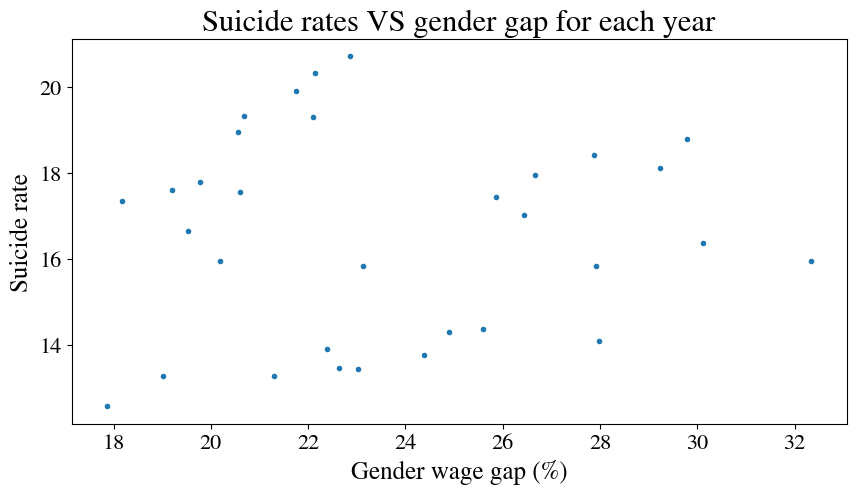

In [62]:
plt.scatter(data.groupby("year").gap.mean(), data.groupby("year").suicides_rate.mean())
plt.title("Suicide rates VS gender gap for each year")
plt.xlabel("Gender wage gap (%)")
plt.ylabel("Suicide rate");

> Next, we will take a look at the relationship between the gender gap and the suicide rates by country. Note that this is possible since we renamed the countries in the gender gap dataset.

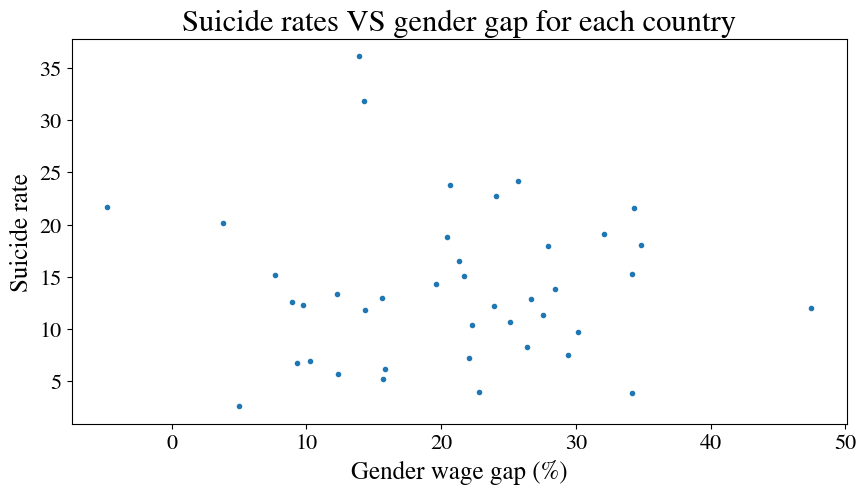

In [63]:
plt.scatter(data.groupby("country").gap.mean(), data.groupby("country").suicides_rate.mean())
plt.title("Suicide rates VS gender gap for each country")
plt.xlabel("Gender wage gap (%)")
plt.ylabel("Suicide rate");

### 4. Extra dataset for complementary analysis

#### Gender inequality index

> This dataset is retrieved from [UNDP](https://hdr.undp.org/data-center/thematic-composite-indices/gender-inequality-index#/indicies/GII) and is about the [Gender Inequality Index](https://en.wikipedia.org/wiki/Gender_Inequality_Index) of different countries from 1990 to 2022. The Gender Inequality Index is a composite measure reflecting inequality in achievements between women and men in three dimensions: reproductive health, empowerment and the labour market. It ranges from 0 to 1 . Being close to 1 refers to high inequality between men-women and close to 0 refers to low inequality.

In [64]:
gii = pd.read_csv(DATAPATH + "gender_inequality_index.csv")
gii.drop_duplicates(keep='first',inplace=True)
gii["average_gii"]= gii.iloc[:,-16:-5].mean(axis=1)
gii.head()

ISO3               Country Continent           Hemisphere  \
0  AFG           Afghanistan      Asia  Northern Hemisphere   
1  AGO                Angola    Africa  Southern Hemisphere   
2  ALB               Albania    Europe  Northern Hemisphere   
3  AND               Andorra    Europe  Northern Hemisphere   
4  ARE  United Arab Emirates      Asia  Northern Hemisphere   

  Human Development Groups UNDP Developing Regions  HDI Rank (2021)  \
0                      Low                      SA            180.0   
1                   Medium                     SSA            148.0   
2                     High                     ECA             67.0   
3                Very High                     NaN             40.0   
4                Very High                      AS             26.0   

   GII Rank (2021)  Gender Inequality Index (1990)  \
0            167.0                             NaN   
1            136.0                           0.725   
2             39.0                             NaN   
3              NaN                             NaN   
4             11.0                           0.659   

   Gender Inequality Index (1991)  ...  Gender Inequality Index (2013)  \
0                             NaN  ...                           0.728   
1                           0.723  ...                           0.540   
2                             NaN  ...                           0.225   
3                             NaN  ...                             NaN   
4                           0.647  ...                           0.161   

   Gender Inequality Index (2014)  Gender Inequality Index (2015)  \
0                           0.718                           0.706   
1                           0.531                           0.530   
2                           0.219                           0.204   
3                             NaN                             NaN   
4                           0.151                           0.126   

   Gender Inequality Index (2016)  Gender Inequality Index (2017)  \
0                           0.692                           0.678   
1                           0.529                           0.538   
2                           0.191                           0.170   
3                             NaN                             NaN   
4                           0.118                           0.112   

   Gender Inequality Index (2018)  Gender Inequality Index (2019)  \
0                           0.671                           0.665   
1                           0.537                           0.537   
2                           0.164                           0.156   
3                             NaN                             NaN   
4                           0.103                           0.056   

   Gender Inequality Index (2020)  Gender Inequality Index (2021)  average_gii  
0                           0.674                           0.678     0.735636  
1                           0.537                           0.537     0.558818  
2                           0.156                           0.144     0.243455  
3                             NaN                             NaN          NaN  
4                           0.050                           0.049     0.179455  

[5 rows x 41 columns]

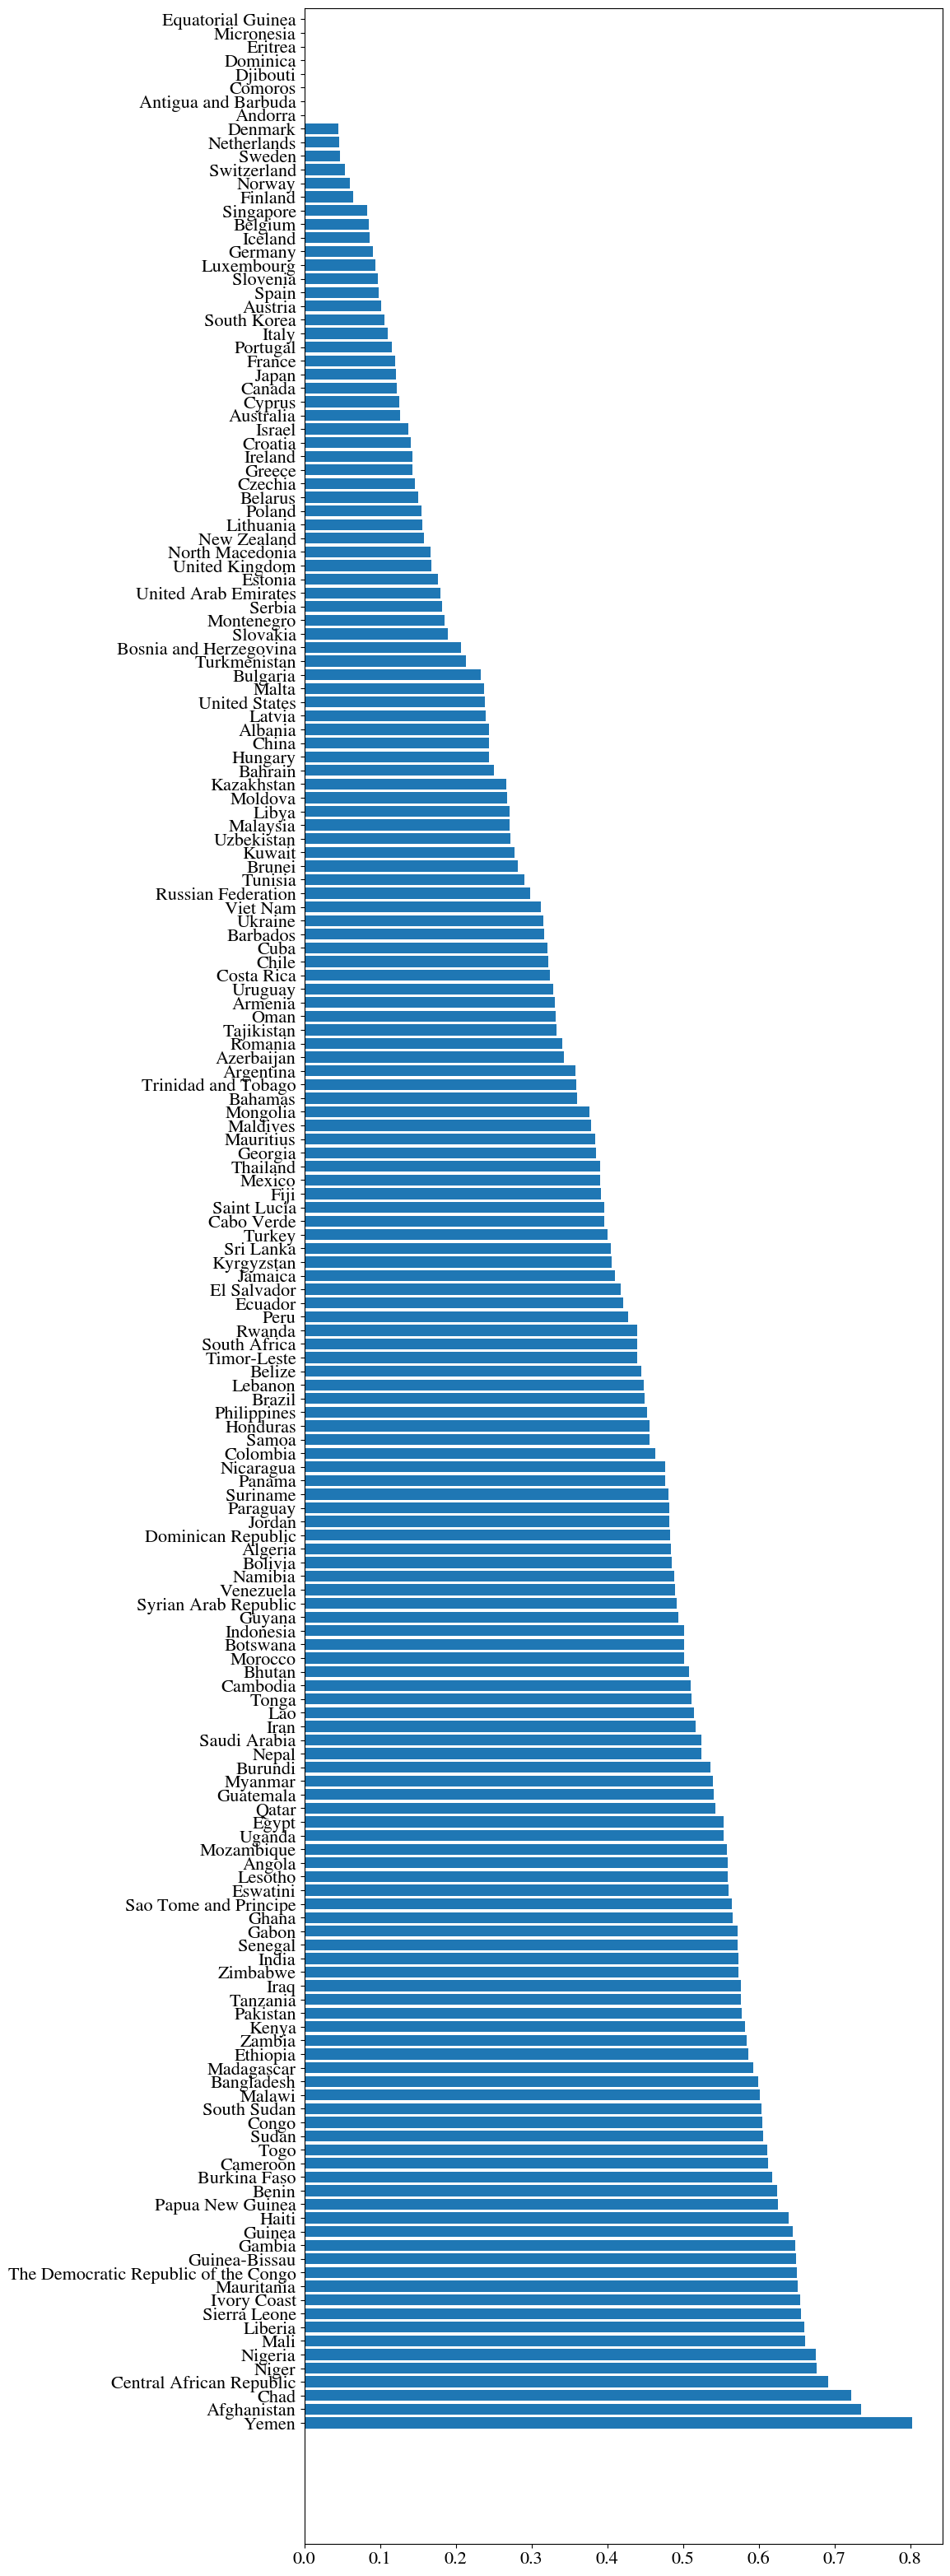

In [65]:
plt.figure(figsize=(10, 40))  # Adjust the figure size if needed
gii_sorted = gii.sort_values(by='average_gii', ascending=False)
plt.barh(gii_sorted['Country'], gii_sorted['average_gii']);

In [66]:
if USEPX:
    fig = px.choropleth(gii, locations="ISO3",
                    color="average_gii", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
    fig.show()

Thanks to this world map plot, we see that the Gender Inequality Index is generally higher in the african countries , Middle East, and some south and southeast asian countries. In Europe, the GII is generally lower, indicates that they have better equality between male-female.

Denmark, Netherland, Sweden, Switzerland, has the lowest GII meaning that there are low inequality between male-female. Whereas, Chad, Afghanistan and Yemen has the highest GII, suggesting that there are less equality in those countries.

> ### Suicide ratio between male-female

This dataset was retrieved from [WHO](https://ourworldindata.org/grapher/male-female-ratio-suicides-rates?tab=map&time=2016) shows us about the ratio of suicide between male and female. A ratio greater than one indicates suicide rates are higher in men. 
It is worth remark that the 


male-female suicide ratio = male suicide rate / female suicide rate. 
Therefore
- low male-female suicide ratio : means high female suicide rate in comparison to male's, which make the fraction small.
This doesn't mean that the female suicide rate is high in general comparing to other countries. But it rather means that it is high compare to men's.
- high male-female suicide ratio : means low female suicide rate in comparison to male's, which make the fraction big



In [67]:
suicides_ratio = pd.read_csv("data/male-female-ratio-suicides-rates.csv")
suicides_ratio= suicides_ratio.rename(columns={'Entity':'Country','Male to female suicide death rate ratio':'male_female_suicide_ratio'})
suicides_ratio = suicides_ratio[(suicides_ratio['Year'] >= 2006) & (suicides_ratio['Year'] <= 2016)]
suicides_ratio = suicides_ratio.groupby(['Country']).aggregate({'male_female_suicide_ratio':'mean','Code': 'first'}).reset_index()
suicides_ratio.sort_values('male_female_suicide_ratio').head()


Country  male_female_suicide_ratio Code
6   Antigua and Barbuda                   0.219477  ATG
0           Afghanistan                   1.058128  AFG
80                India                   1.403185  IND
99              Liberia                   1.480046  LBR
36                China                   1.518355  CHN

<BarContainer object of 194 artists>

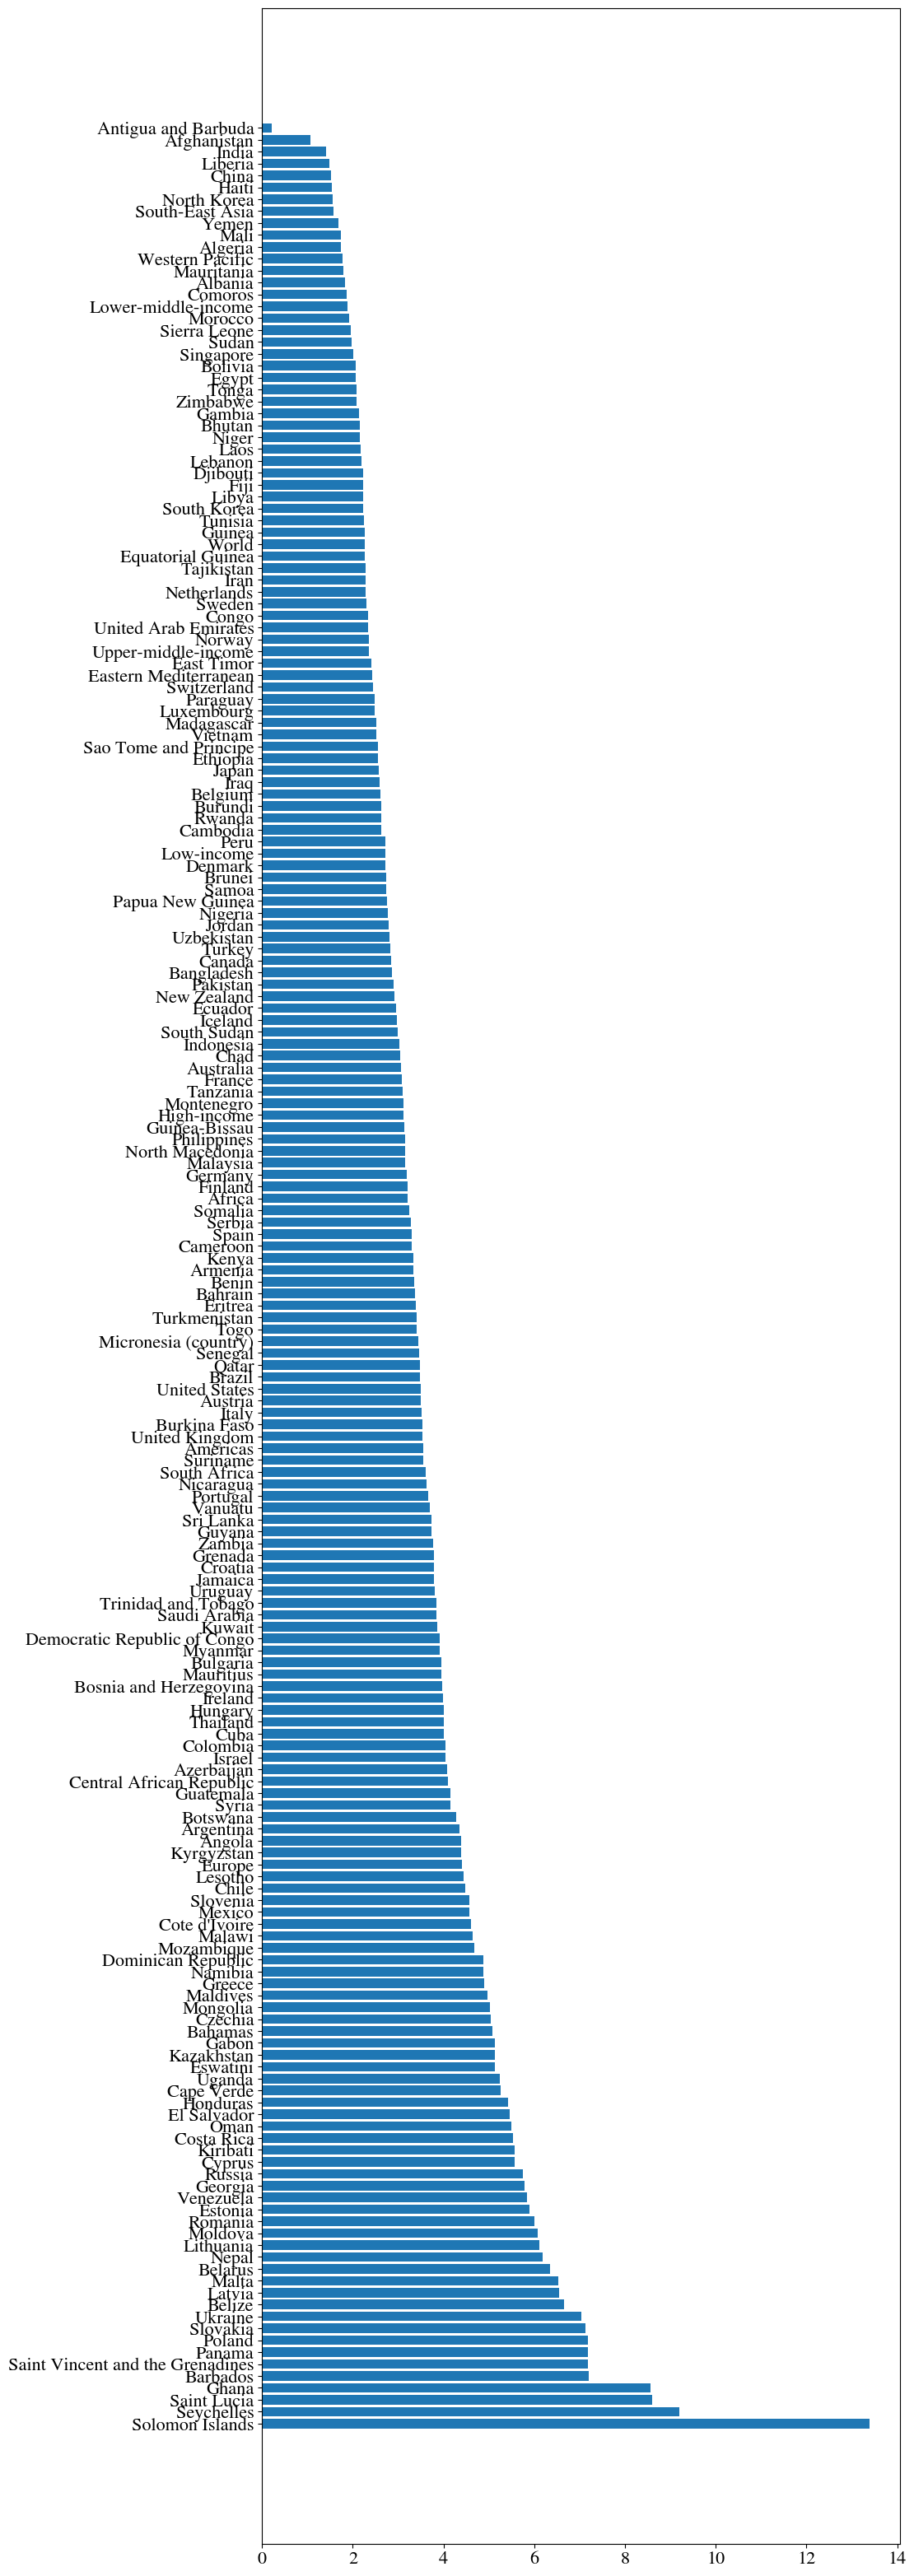

In [68]:
plt.figure(figsize=(10, 40))  # Adjust the figure size if needed
suicides_ratio_sorted = suicides_ratio.sort_values(by='male_female_suicide_ratio', ascending=False)
plt.barh(suicides_ratio_sorted['Country'], suicides_ratio_sorted['male_female_suicide_ratio'])

In [69]:
if USEPX:
    fig = px.choropleth(suicides_ratio, locations="Code",
                        color="male_female_suicide_ratio", 
                        hover_name="Country", # column to add to hover information
                        color_continuous_scale=px.colors.sequential.Plasma)
    fig.show()

> Thanks to plot above, we see that Antigua and Barbuda has 0.2 male-female suicide ratio, which is the only country who has more female suicide rate than male's. Otherwise, the value are all above 1. , suggesting that there are more male committing suicide than female do. Liberia,Afghanistan,India has lowest male-female suicide ratio, meaning that the fraction of female suicide rate are also as high as the fraction of male suicide rate. Whereas, in countries such as Solomon island, Seychelles, Saint lucia, have the highest male-female suicide ratio. This means that in those countries , there are less female committing suicide in comparison to male.

### Sex ratio at birth

> This dataset show us about the ratio between male to female at birth (from [WHO]()). This ratio might be useful for analysis of inequality because in some countries, people prefer having a son than a daughter due to some cultural perspective. 

In [70]:
sex_birth_ratio = pd.read_csv(DATAPATH +'sex-ratio-at-birth.csv')
sex_birth_ratio = sex_birth_ratio.rename(columns={"Entity": "Country","Sex ratio - Sex: none - Age: at birth - Variant: estimates": "sex_ratio_at_birth"})
sex_birth_ratio['sex_ratio_at_birth'] = sex_birth_ratio.sex_ratio_at_birth/100

sex_birth_ratio= sex_birth_ratio[(sex_birth_ratio['Year']>=2006) & (sex_birth_ratio['Year']<=2016)]
sex_birth_ratio = sex_birth_ratio.groupby("Country").agg({"sex_ratio_at_birth": 'mean', 'Code':'first'}).reset_index()

sex_birth_ratio.head()

Country  sex_ratio_at_birth  Code
0     Afghanistan            1.059364   AFG
1     Africa (UN)            1.035727  None
2         Albania            1.107091   ALB
3         Algeria            1.048091   DZA
4  American Samoa            1.060000   ASM

In [71]:
if USEPX:
    fig = px.choropleth(sex_birth_ratio, locations="Code",
                        color="sex_ratio_at_birth", 
                        hover_name="Country", # column to add to hover information
                        color_continuous_scale=px.colors.sequential.Plasma)
    fig.show()

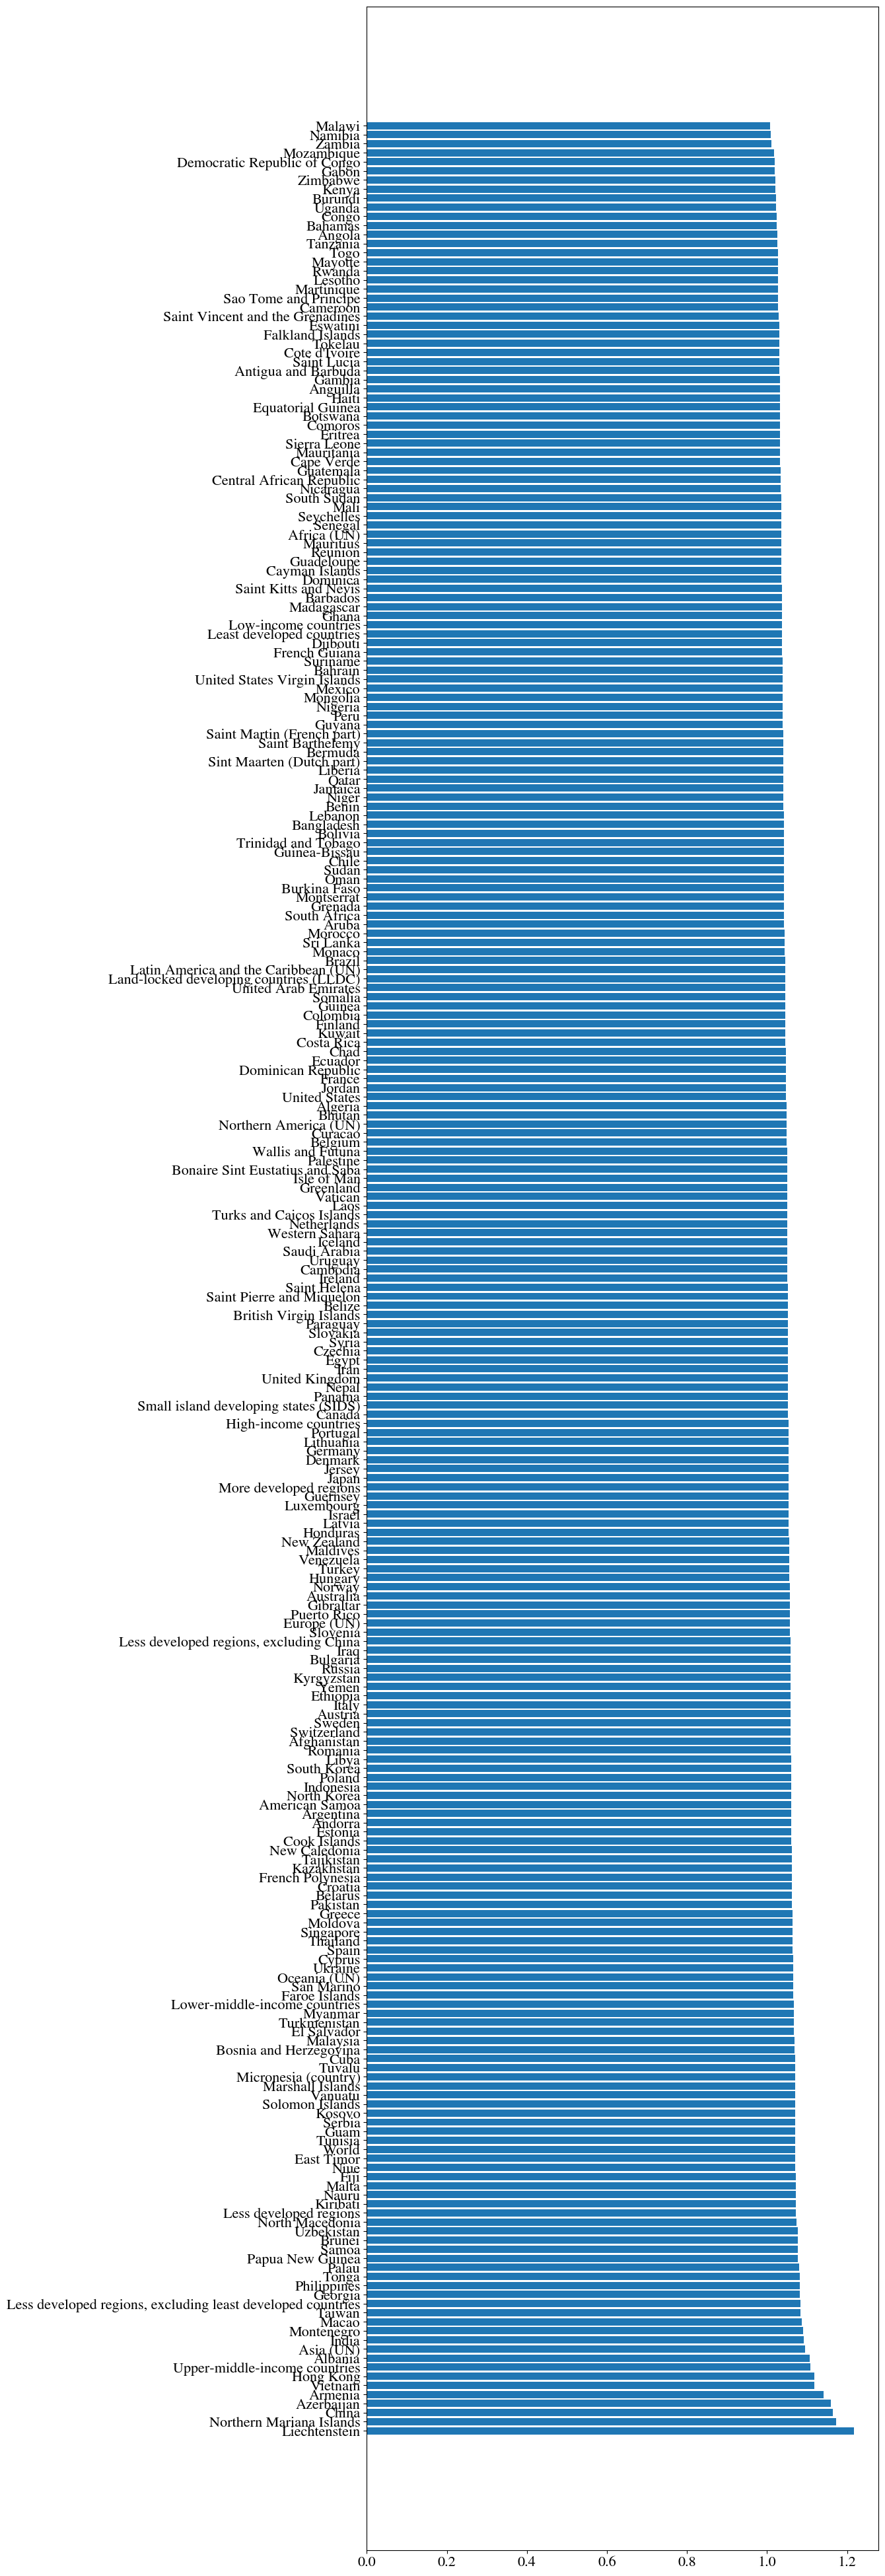

In [72]:
sex_birth_ratio_sorted = sex_birth_ratio.sort_values(by='sex_ratio_at_birth', ascending=False)
plt.figure(figsize=(10, 50))  # Adjust the figure size if needed
plt.barh(sex_birth_ratio_sorted['Country'], sex_birth_ratio_sorted['sex_ratio_at_birth']);

We see that the ratio between male and female at birth is higher in asian in general such as China, Vietnam, or Hongkong and some other european countries as well such as Liechtenstein and Armenia. This might due to cultural factor where the son is more preferred over daughter that make it one of the parameter we take into account for inequality.

## III. Models exploration

> In this section, we use the data we prepared and visualized in the previous section to build a model allowing us to describe the suicide rates depending on variables such as country, year but also economical data such as GDP or gender wage gap. The major goal of this section is to compare different models in order to find the one that explains the best our data. <br>
> We start by spliting the data into a training and a testing set and then build models on our data. For each model, we fit it to the data and the evaluate its performance. Then we try to conclude on the best model for this task, and fit it on the whole dataset.
>
> ### Train / test split
>
> In order to train a model and evaluate its performance, we need at least two datasets:
> - a training set (`train`), that is used to fit the model (compute the parameters of the model)
> - a testing set (`test`), that is not used to fit the model, only to measure its quality. This ensures the model is evaluated on unknown data.
>
> It is necessary to use these two dataset in this section since we need to compare multiple models. Indeed, training a model on the whole data and then evaluating it on the same data could lead to overfitting and hinder the fairness of the resulting score. Here, after fitting the models on the  `train` dataset, we compute the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) on the `test` dataset. We chose this score since it is applicable to any regression model and is commonly used, especially in research, thus making our results easier to compare to future work on the same task. Note that all MSE scores in this section are given on the test set. <br>
> In this work, we have a relativly small/medium sized dataset (604 observations). In order to get good quality evaluation, we choose to keep a relatively high number of rows for the testing set, i.e. 30%. <br>
> We also make a distinction between the features, denoted as `X` in the rest of this notebook and the variable of interest (`suicides_rate`), denoted as `y`.

In [73]:
features = ["year", "gdp", "gdp_per_capita", "hdi", "gap"]

X_train, X_test, y_train, y_test = train_test_split(data[features], data.suicides_rate, test_size=.3, random_state=SEED)

print("Number of observations:")
print(f"   - train: {X_train.shape[0]} ({X_train.shape[0]/data.shape[0]*100:.0f}%)")
print(f"   - test: {X_test.shape[0]} ({X_test.shape[0]/data.shape[0]*100:.0f}%)")

Number of observations:
   - train: 422 (70%)
   - test: 182 (30%)


### 1. Univariate linear regression
>
> The first class of models that we will try to use are simple [univariate linear regressions](https://en.wikipedia.org/wiki/Simple_linear_regression). This model tries to explain the data as much as possible using a linear function taking in account a single variable. <br>
> For each of the five numerical features we are taking in acount (we exclude `country`, that only was a grouping variable), we will create a linear regression model trying to estimate the suicide rate depending on this variable. We will then keep the model minimizing the mean squared error (MSE) on the test set: it will be the best univariate linear regression model.  

In [74]:
def apply_lr(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series) -> tuple[LinearRegression, float]:
    """
    Applies linear regression to the provided train data and returns the model and its MSE on the test data.

    Args:
        X_train (pd.DataFrame)
        y_train (pd.Series)
        X_test (pd.DataFrame)
        y_test (pd.Series)

    Returns:
        tuple[LinearRegression, float]
    """
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_predictions = lr.predict(X_test)
    lr_test_mse = mean_squared_error(y_test, lr_predictions)
    return lr, lr_test_mse

In [75]:
for feature in features:
    if feature != "country":
        _, mse = apply_lr(X_train[feature].values.reshape(-1, 1), y_train, X_test[feature].values.reshape(-1, 1), y_test)
        print(f"MSE for feature {feature}: {mse:.2f}")

MSE for feature year: 43.91
MSE for feature gdp: 45.43
MSE for feature gdp_per_capita: 44.26
MSE for feature hdi: 46.33
MSE for feature gap: 43.94


> As we can see from the output above, all of the five univariate linear regression have similar MSE score, althought two of them seem better than the others, the one describing the suicide rate depending on the variables:
> - `year`
> - `gap`
>
> We will keep the very best model, using the `year` variable, since it gets the best MSE on the test set: **43.91**. <br>
> Let us now visualize how this model fits the data on a 2D graph.

In [76]:
# Fit the best model on the training data
univariate_regression = LinearRegression().fit(X_train.year.values.reshape(-1, 1), y_train)

# Predict for the test data
univariate_regression_predictions = univariate_regression.predict(X_test.year.values.reshape(-1, 1))

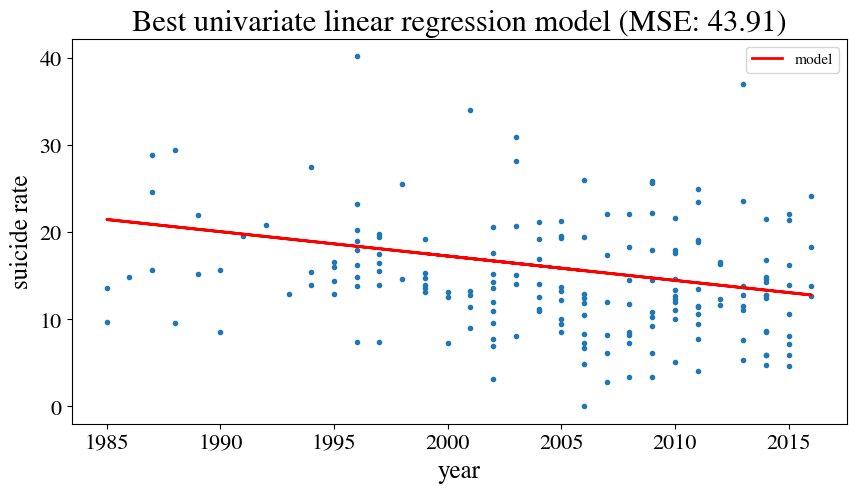

In [77]:
title = f"Best univariate linear regression model (MSE: {mean_squared_error(y_test, univariate_regression_predictions):.2f})"
plt.scatter(X_test.year, y_test)
plt.plot(X_test.year, univariate_regression_predictions, label="model", color = "red")
plt.title(title)
plt.xlabel("year")
plt.ylabel("suicide rate")
plt.legend();

> The graph above shows us how the model tries to fit the data as well as possible, but simply cannot due to how spread the data is. I shows the need to either use another model or add more variable in the model. We will do both, starting by the later option in the next section. We will see that adding more explanatory variables helps increasing the performance of our model to explain the suicide rate.

### 2. Multivariate linear regression
>
> As we saw in the previous section with the univariate linear regression models, apparently considering a single variable is not enough. That is why, in this section, we use multiple variables to perform better linear regressions. The class of models we consider here are the [multivariate linear regression](https://en.wikipedia.org/wiki/Linear_regression) models. It works in the same way as the univariate linear regression model, but takes in account as many variables as needed. <br>
> Instead of considering all variables, which might lead to over-fitting depending on our data, we will perform [feature selection](https://en.wikipedia.org/wiki/Feature_selection). This process is usually done through forward or backward feature selection to avoid testing all feature combinations, but since we only consider five numerical features, there only are $25 = 5^2$ models to consider in total which is reasonable enough to test them all and choose the one with the lowest MSE on the testing set. <br>

In [78]:
def lr_feature_selection(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
    """
    Uses the MSE score to give the best features to use in a linear regression model.

    Args:
        X_train (pd.DataFrame)
        y_train (pd.Series)
        X_test (pd.DataFrame)
        y_test (pd.Series)

    Returns:
        dict: a dict where the keys are tuples of selected variables (their names) and the values are the associated MSE. Sorted in ascending MSE order (first element is the best model)
    """
    features = list(X_train.columns)
    mse =  {} # stores the aic associated to each feature selection
    for selected_features in powerset(features):
        if selected_features: # ignores the empty list
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]
            _, model_mse = apply_lr(X_train_selected, y_train, X_test_selected, y_test)
            mse[tuple(selected_features)] = model_mse
    return sort_by_value(mse)

In [79]:
sorted_mse = lr_feature_selection(X_train[["year", "gdp", "gdp_per_capita", "hdi", "gap"]], y_train, X_test[["year", "gdp", "gdp_per_capita", "hdi", "gap"]], y_test)
best_features = list(sorted_mse.keys())[0]
best_mse = sorted_mse[best_features]
best_features = list(best_features)

print(f"Best MSE: {best_mse:.2f}")
print_list(best_features, f"Obtained with {len(best_features)} features")

Best MSE: 43.25
Obtained with 3 features:
  • gdp_per_capita
  • hdi
  • gap


> The best multivariate linear regression model is thus the one taking in account the three variables `gdp_per_capita`, `hdi` and `gap`, which intuitively makes sense. However, the MSE improvement over the univariate is very small. Indeed, the MSE of the multivariate model is 43.25, against 43.91 for the best univariate linear regression model. <br>
> This shows the need to introduce another class of models, which will be able to explain our data better. Due the nature of said data, we will try to explore the decision tree model in the next section.

### 3. Decision tree regressor
> In this section, we apply a [decision tree regressor](https://en.wikipedia.org/wiki/Decision_tree_learning) to our data in an attempt at improving the test MSE. This kind of model gradually builds a decision tree based on the model it gains on the training data, trying to maximize the information for each decision split. <br>
> Note that there is no need to perform a feature selection with this kind of models, since it is done automaticaly by the tree during its construction when fitting the training data.

In [80]:
decision_tree = DecisionTreeRegressor(random_state=SEED)
decision_tree.fit(X_train, y_train)
decision_tree_predictions = decision_tree.predict(X_test)
decision_tree_test_mse = mean_squared_error(y_test, decision_tree_predictions)
print(f"Decision tree regressor MSE: {decision_tree_test_mse:.2f}")

Decision tree regressor MSE: 32.47


> The test MSE is quite low compared to the one we get by using simple regression model, showing that using another class of models was indeed the right decision. <br>
> Tasks where decision trees perform well are usually even better modeled by random forest, that is why we will explore this class of models in the next section.

### 4. Random forest regression
>
> After using a decision tree that performed quite well, the only logical step is to try using a [random forest](https://en.wikipedia.org/wiki/Random_forest) on our data. This class of model works by training many very small decision trees on random samples of the training data and then combining the results using the mean of all predicted values. Ensemble methods are quite powerfull so we expect this model to get quite good results on our problem. <br> 
> Due to the relatively low number of observations in our training set, we decided using only using 30 trees in the random forest. We will also restrict the maximum tree depth to 12 to avoid over-fitting, which is frequent with this kind of models.

In [81]:
# Construct the model
random_forest = RandomForestRegressor(
    n_estimators=30,
    max_depth=12,
    random_state=SEED
)

# Train the model
random_forest.fit(X_train, y_train)

# Make prediction on test data
random_forest_predictions = random_forest.predict(X_test)

# Compute MSE for comparing with the other models
random_forest_test_mse = mean_squared_error(y_test, random_forest_predictions)
print(f"Random forest regressor MSE: {random_forest_test_mse:.2f}")

Random forest regressor MSE: 16.43


> As we can see, using a random forest greatly reduces the MSE on the testing set, yielding the best test MSE yet, 16.43, against about 40 for linear regressions and 32 for the decision tree we have tried before. <br>
> A great asset of random forest is that they allow us to see which features had the most impact during training. This allows us to see on which variables authorities could work on to reduce the suicide rate eventually.

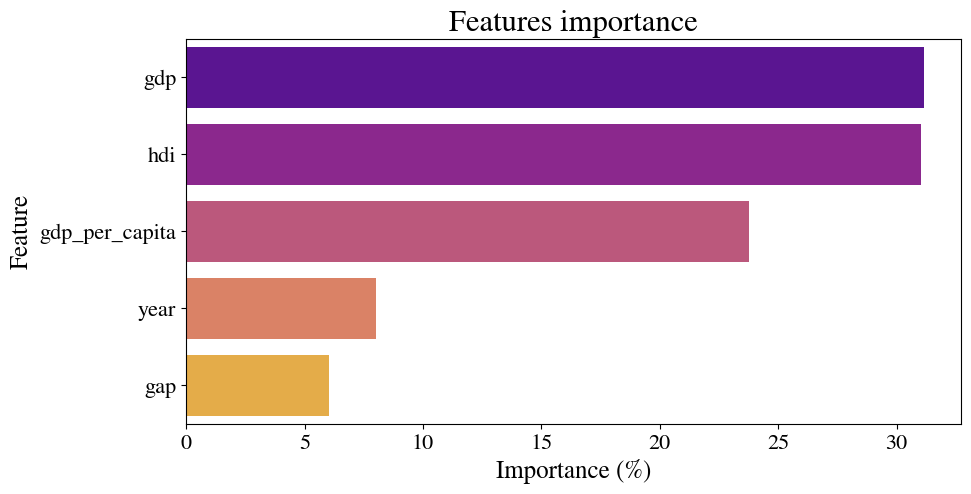

In [82]:
# Get features importance and put sort them
feature_importances = random_forest.feature_importances_
feature_importance_dict = {features[i]: feature_importances[i] for i in range(len(features))}
importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Convert from the [0, 1] interval to [0, 100] to get the importance in percents
importance_df["Importance"] = importance_df.Importance*100

# Plot the result
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="plasma")
plt.title("Features importance")
plt.xlabel("Importance (%)")
plt.ylabel("Feature")
plt.show()

> Our random forest thus gives the most importance to the three following features:
> - `gdp`
> - `hdi`
> - `gdp_per_capita`
>
> While the two remaining features, `year` and `gap`, only have less the 15% of importance combined, meaning the other features are enough to explain about 85% of the variance contained in the training data. <br>
> The interpretation of this result could be usefull since it shows that in order to reduce suicide rate, working on economical variables (GDP and HDI) is more efficient than working on the gender gap. <br>
> *Disclaimer: the gender gap still have tons of other negative consequences, so it is not an issue to disregard.*

### 5. Principal Components Analysis
>
> After examining the graphs we made during the EDA, we can observe that some groups start forming along different axis. This observation leads us to consider using a [PCA (Principal Component Analysis)](https://en.wikipedia.org/wiki/Principal_component_analysis) to improve the results of our models (especially the multivariate linear regressions). This method tries to find the axis that explain the most of the variance in the data to build a new space in which most of the data is explained by the first axis. Then, we expect a linear regression to get better result in this new space. <br>
>
> #### Applying PCA
> PCA requires all variables to have the samee distribution, otherwise more importance could be given to variables with a high variance, or with a mean far from 0. In order to prepare the data for the PCA, we thus need to standardize it.

In [83]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train[["year", "gdp", "gdp_per_capita", "hdi", "gap"]])
X_test_std = scaler.transform(X_test)

In [84]:
pca = PCA().fit(X_train_std, y_train)

> A good practice after applying PCA is to take a look at the variance explained by each principal component. Not only it prevents us from not detecting issues in our method but it also allows us to detect high correlation in our data.

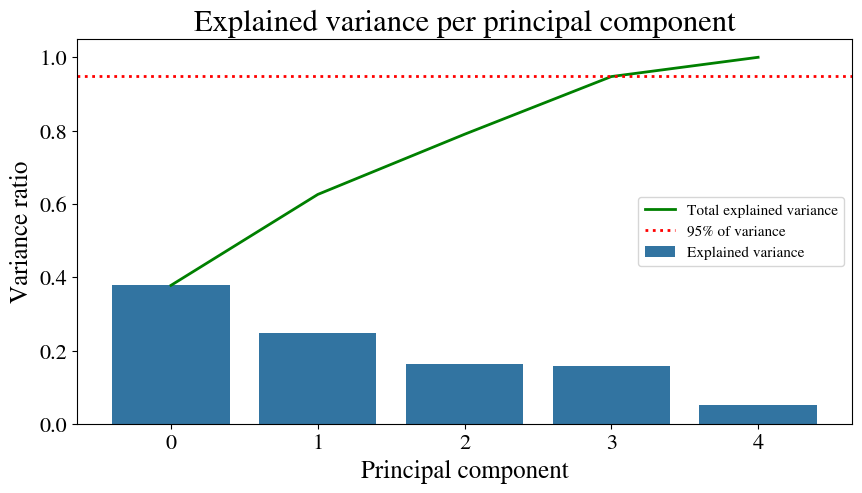

In [85]:
sns.barplot(pca.explained_variance_ratio_, label = "Explained variance")
sns.lineplot(np.cumsum(pca.explained_variance_ratio_), color ="green", label = "Total explained variance")
plt.axhline(.95, linestyle = ":", color = "red", label = "95% of variance")
plt.title("Explained variance per principal component")
plt.xlabel("Principal component")
plt.ylabel("Variance ratio")
plt.legend();

> The variables we choose seem to have reasonnable correlation. From the graph above, only the 4 first principal components are necessary to explain 95% of the variance contained in the training data, but we choose to keep the last component. Let us now visualize the importance of ech original feature in the new principal components.

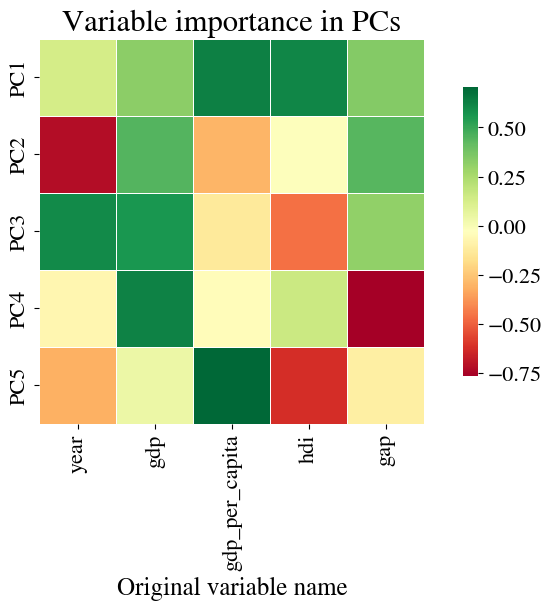

In [86]:
sns.heatmap(pca.components_,
            xticklabels=["year", "gdp", "gdp_per_capita", "hdi", "gap"], yticklabels=[f"PC{n+1}" for n in range(len(pca.components_))],
            cmap="RdYlGn", cbar_kws={"shrink": .75},
            square=True, linewidths=.5)
plt.title("Variable importance in PCs")
plt.xlabel("Original variable name");

> ### Linear regression after PCA
Now that PCA has been apply, we will fit a linear regression model on the transformed data. As discussed above, we will use all principal components in our model, but we expect the last one to have a smaller weight.

In [87]:
X_train_std_df = pd.DataFrame(X_train_std, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
X_test_std_df = pd.DataFrame(X_test_std, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])

In [88]:
_, pca_regression_mse = apply_lr(X_train_std_df, y_train, X_test_std_df, y_test)
print(f"MSE of the PCA regression model: {pca_regression_mse:.2f}")

MSE of the PCA regression model: 44.55


> Apparently, applying PCA was not a good way to improve our results, since the MSE on the test set is higher than for the rest of what we have tried before. We will not use PCA for the rest of the study, but it still was usefull to explain some of the correlation between the variables.

### 6. Partial conclusion on the different models
> The test MSE scores can be summarized in the following table:

| Model                          | Test MSE |
| ------------------------------ | -------- |
| Univariate linear regression   | 43.91    |
| Multivariate linear regression | 43.25    |
| Decision tree regressor        | 32.47    |
| Random forest regressor        | 16.43    |
| Linear regression after PCA    | 44.55    |

> Based on this score, we will only consider using a random forest for the rest of our study. In the next section, we will apply this model on our whole dataset.

## Final model
> In this section, we fit a random forest on the whole dataset. Indeed, the train/test split was only used in order to compare the different models and select the best one, but for better prediction in the future, it is beneficial to use all the data we have.

In [89]:
final_model = RandomForestRegressor(
    n_estimators=30,
    max_depth=12
)
final_model.fit(data[["year", "gdp", "gdp_per_capita", "hdi", "gap"]], data["suicides_rate"])

RandomForestRegressor(max_depth=12, n_estimators=30)

> To make a prediction on the future data, we can simply use the `predict` method on `final_model`. <br>
> The following cell gives an example on how to use our model on sample data.

In [90]:
sample_data = np.array([2017.0, 5.5+11, 5.6e+04, .9, 10], dtype=float)
sample_prediction = final_model.predict(sample_data.reshape(1, -1))[0]

print(f"Predicted suicide rate on the sample data point (in suicides per 100k people): {sample_prediction:.1f}")

Predicted suicide rate on the sample data point (in suicides per 100k people): 15.6


## IV. Complementary Analysis



> In this section, besides analysing on different variable on the number of total suicide, we do a further analysis to see if inequality variable such as gender inequality index and sex-ratio at birth has some effects on the male-female suicide ratio.

In [91]:
merge_df= pd.merge(suicides_ratio,gii[["Country","average_gii"]],how='inner',left_on='Country', right_on='Country')
merge_df = pd.merge(merge_df, sex_birth_ratio[["Country","sex_ratio_at_birth"]],how='left',left_on='Country', right_on='Country')

merge_df = merge_df.dropna()

merge_df.head()

Country  male_female_suicide_ratio Code  average_gii  \
0  Afghanistan                   1.058128  AFG     0.735636   
1      Albania                   1.822882  ALB     0.243455   
2      Algeria                   1.743743  DZA     0.483727   
3       Angola                   4.381303  AGO     0.558818   
5    Argentina                   4.348375  ARG     0.358545   

   sex_ratio_at_birth  
0            1.059364  
1            1.107091  
2            1.048091  
3            1.025273  
5            1.060455

## Univariate Linear Regression
> The model can be written as:
> $$
>     Y = aX + b
> $$
> where:
>- $Y$ is the ratio of male to female suicide rate,
>- $X$ is the gender inequality index.

In [92]:
X = merge_df["average_gii"]  # Independent variable
y = merge_df["male_female_suicide_ratio"]  # Dependent variable

# Add a constant term to the independent variable (for the intercept)
X_with_intercept = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X_with_intercept).fit()

# Print the summary statistics
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     male_female_suicide_ratio   R-squared:                       0.027
Model:                                   OLS   Adj. R-squared:                  0.021
Method:                        Least Squares   F-statistic:                     4.464
Date:                       Sun, 21 Jan 2024   Prob (F-statistic):             0.0362
Time:                               14:53:38   Log-Likelihood:                -289.70
No. Observations:                        161   AIC:                             583.4
Df Residuals:                            159   BIC:                             589.6
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

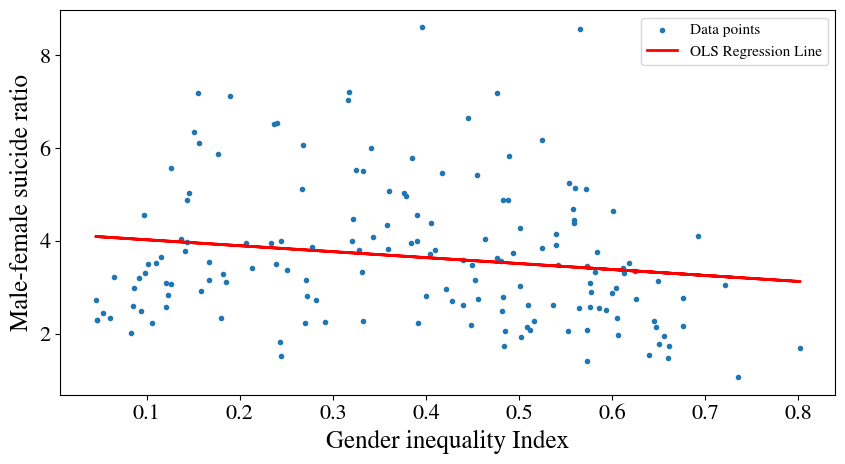

In [93]:
plt.scatter(X, y, label='Data points')

# Plot regression line using the model's fitted values
plt.plot(X, model.fittedvalues, color='red', label='OLS Regression Line')
plt.xlabel('Gender inequality Index')
plt.ylabel('Male-female suicide ratio')
plt.legend()

# Show the plot
plt.show()

> Thank to the summary of model above, we remark that the coefficient of GII is  **-1.2817** , suggesting that as GII increases, the male-female suicide ratio decrease. This is to say that a country with high inequality between men-women has lower male-female suicide ratio. Low male-female suicide ratio means that there are high female suicide rate to the male suicide rate. Therefore in simple word , a country with high inequality has more female who commit suicide and vice-versus.
>
> However, we see that the p-value is  **3.6%** which is lower than **5%** which tell us that with this variable is statistically significant. Therefore, we can interpret that a country with low inequality index results in reduction of female suicide rate. 


## Multi-variate Linear Regression
> Now let us add some other independent variables to see their effect on the suicide ratio. <br>
> The model can be written as:
> $$
>     Y = aX_{1} + bX_{2} + c
> $$
> Where:
>- $Y$ is the ratio of male to female suicide rate,
>- $X_{1}$ is the gender inequality index,
>- $X_{2}$ is the ratio of male-female at birth.

In [94]:
X = merge_df[['average_gii','sex_ratio_at_birth']] # Independent variable
y = merge_df['male_female_suicide_ratio']  # Dependent variable

# Add a constant term to the independent variable (for the intercept)
X_with_intercept = sm.add_constant(X)

# Fit the linear regression model
model2 = sm.OLS(y, X_with_intercept).fit()

# Print the summary statistics
print(model2.summary())

                                OLS Regression Results                               
Dep. Variable:     male_female_suicide_ratio   R-squared:                       0.053
Model:                                   OLS   Adj. R-squared:                  0.041
Method:                        Least Squares   F-statistic:                     4.444
Date:                       Sun, 21 Jan 2024   Prob (F-statistic):             0.0133
Time:                               14:53:38   Log-Likelihood:                -287.53
No. Observations:                        161   AIC:                             581.1
Df Residuals:                            158   BIC:                             590.3
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

> When incorporating the additional inequality parameter, sex ratio at birth, distinct findings emerge. The coefficients for GII, and sex ratio at birth are **-1.7878, -11.88**, respectively. This implies that:
> 
> - A higher level of country inequality (GII) corresponds to a lower male-female suicide rate, indicating a higher female suicide rate, and vice versa.
> - An elevated sex ratio at birth is associated with a lower male-female suicide rate, suggesting a higher female suicide rate, and vice versa. This implies that cultural factors, such as son-preference over daughter, contributing to the inequality between the sexes at birth may also play a role.
> 
> Moreover, the p-values for both variables are **0.6% and 3.9%**, respectively, which are relatively smaller than in the previous univariate model.
> Assuming an alpha level of 5%, this model becomes statistically significant, leading to the conclusion that lower inequality between men and women which include lower GII and sex-ratio-at-birth has an impact on the reduction of female suicide.
> 
> It is noteworthy that countries exhibit different levels of human development. Considering this, stratifying the data into distinct groups based on their human development levels becomes crucial for a furthur comprehensive analysis.

## V. General conclusion
>
> In this work, we have considered two datasets. The first one described the suicide rate of different populations, comming from different regions of the world with different economical variables such as the GDP or the HDI. The second one was smaller and contained information about the gender wadge gap from many countries over the years. Joined together, these two datset allowed us to build a more comprehensive one, that we use to build a model describing the suicide rate depending on five main variables: the time (year), the GDP, the GDP per capita, the HDI and the gender wadge gap.
We then tried using five different models to describe the suicide rate depending on these variables: univariate and multivariate linear regressions (with feature selection), a decision tree, a random forest and finally a linear regression after applying a PCA on our data. It was found that a random forest was the best model for our problem, we thus applied it on our whole dataset and built a model ready for future predictions. It allowed us to see that the GDP and the HDI where the variables that better described the suicide rate, although all variables seem to be important for the model.
We also tried another approach, using linear regression to find a relationship between the ratio of male/female suicides depending on the Gender Inequality Index and the ratio of male/female birth. This complementary analysis lead to the conclusion that both of these variable indeed had an influence on the male/female suicide ratio leading to a conclusion that female might commit suicide more than men do in a country with high inequality between men-women.
For further work, it could be interesting to take in account more variables, especially variables regarding the localisation of the considered population. Indeed, even though our models describe the suicide rate quite well, going deeper and being more precise could lead to better result. Note that for future predictions, it would require more data.